In [1]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

# Unzip runs.zip in NASLib/run/results/correlation before running the code

In [2]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

def get_all_files(root_folder='../run/results/correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_nested_dict(files):

    data = {}

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]

        with open(file, 'r') as f:
            scores = json.load(f)[1]

        if search_space not in data:
            data[search_space] = {}
        if dataset not in data[search_space]:
            data[search_space][dataset] = {}
        if predictor not in data[search_space][dataset]:
            data[search_space][dataset][predictor] = {
                'kendalltau': [],
                'pearson': [],
                'spearman': []
            }
            

        data[search_space][dataset][predictor]['kendalltau'].append(scores['kendalltau'])
        data[search_space][dataset][predictor]['pearson'].append(scores['pearson'])
        data[search_space][dataset][predictor]['spearman'].append(scores['spearman'])
    
    return data

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]
        
        with open(file, 'r') as f:
            scores = json.load(f)[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'predictor': predictor,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        data.append(record)

    return data

def plot_heatmap(df, figsize=(18, 6), rotation=0, title=''):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap='viridis')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation)
    
    
def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['predictor', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'predictor')
    
    print('PIVOT TABLE')
    print(pivot_df)
    print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['predictor'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['predictor'] == zc_2]['preds'].to_list()[0])
            
            try:
                if len(preds_1) != len(preds_2):
                    print(zc_1, zc_2, len(zc_1), len(zc_2), 'prediction sizes do not match')
                    continue
            except:
                print(zc_1, preds_1)
                print(zc_2, preds_2)
                
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        print(f'Computing correlation for {search_space} {dataset} {seed}')
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        
#         print(df_)
        predictors = tuple(set(df_['predictor'].to_list())) # List of predictor names
#         print('Predictors used to compute correlation: ', predictors)
        correlation = compute_correlation(df_, predictors)
        print('correlation shape', correlation.shape)
        all_corrs.append(correlation)

#     print('all_corrs ::', np.array(all_corrs))
    corr = np.mean(np.array(all_corrs), axis=0)
#     print('mean corrs ::', corr.shape)
    corr_df = pd.DataFrame(corr)

    predictors_map = {i: predictors[i] for i in range(len(predictors))}
    corr_df = corr_df.rename(columns=predictors_map, index=predictors_map)
    plot_heatmap(corr_df, title=f'ZC Correlation for {search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'predictor'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_predictors_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'predictor'])[metric].mean()
    
#     print('pred scores')
#     print(pred_scores)
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            #print(searchspace, dataset)
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

#     print('SERIES')
#     print(series[0])

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s, left_index=True, right_index=True)

    return idf

def count_nans(df, col):
    n_wrong = 0
    wrong_ones = []
    indices = []

    for idx, p in enumerate(list(df['preds'])):
        if len(p) != 200:
            n_wrong += 1
            wrong_ones.append(len(p))
            indices.append(idx)

    return n_wrong, wrong_ones, indices

def clean_df(df):
#     print(df[df['ground_truth'].isna()])
    df = df.dropna(axis=0, subset=['ground_truth'])
    return df

with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
    data = json.load(f)

def create_clean_df(preds_to_drop=None):
    files = get_all_files()
    df = make_df(files)
    df = clean_df(df)

    _, _, indices = count_nans(df, 'preds')
    
    df.drop(index=indices)

    if preds_to_drop is not None:
        for predictor in preds_to_drop:
            df = df[df['predictor'] != predictor]
    
    return df

def filter_df(df, search_space, dataset, seed):
    return df[
        (df['search_space'] == search_space) &
        (df['dataset'] == dataset) &
        (df['seed'] == seed)
    ]

Empty DataFrame
Columns: [search_space, dataset, predictor, seed, kendalltau, pearson, spearman, preds, ground_truth]
Index: []
Computing correlation for nasbench201 cifar10 9000
correlation shape (12, 12)
Computing correlation for nasbench201 cifar10 9001
correlation shape (12, 12)
Computing correlation for nasbench201 cifar10 9002
correlation shape (12, 12)
Computing correlation for nasbench201 cifar10 9003
correlation shape (12, 12)
Computing correlation for nasbench201 cifar10 9004
correlation shape (12, 12)
Computing correlation for nasbench201 cifar100 9000
correlation shape (12, 12)
Computing correlation for nasbench201 cifar100 9001
correlation shape (12, 12)
Computing correlation for nasbench201 cifar100 9002
correlation shape (12, 12)
Computing correlation for nasbench201 cifar100 9003
correlation shape (12, 12)
Computing correlation for nasbench201 cifar100 9004
correlation shape (12, 12)
Computing correlation for nasbench201 ImageNet16-120 9000
correlation shape (12, 12)
Co

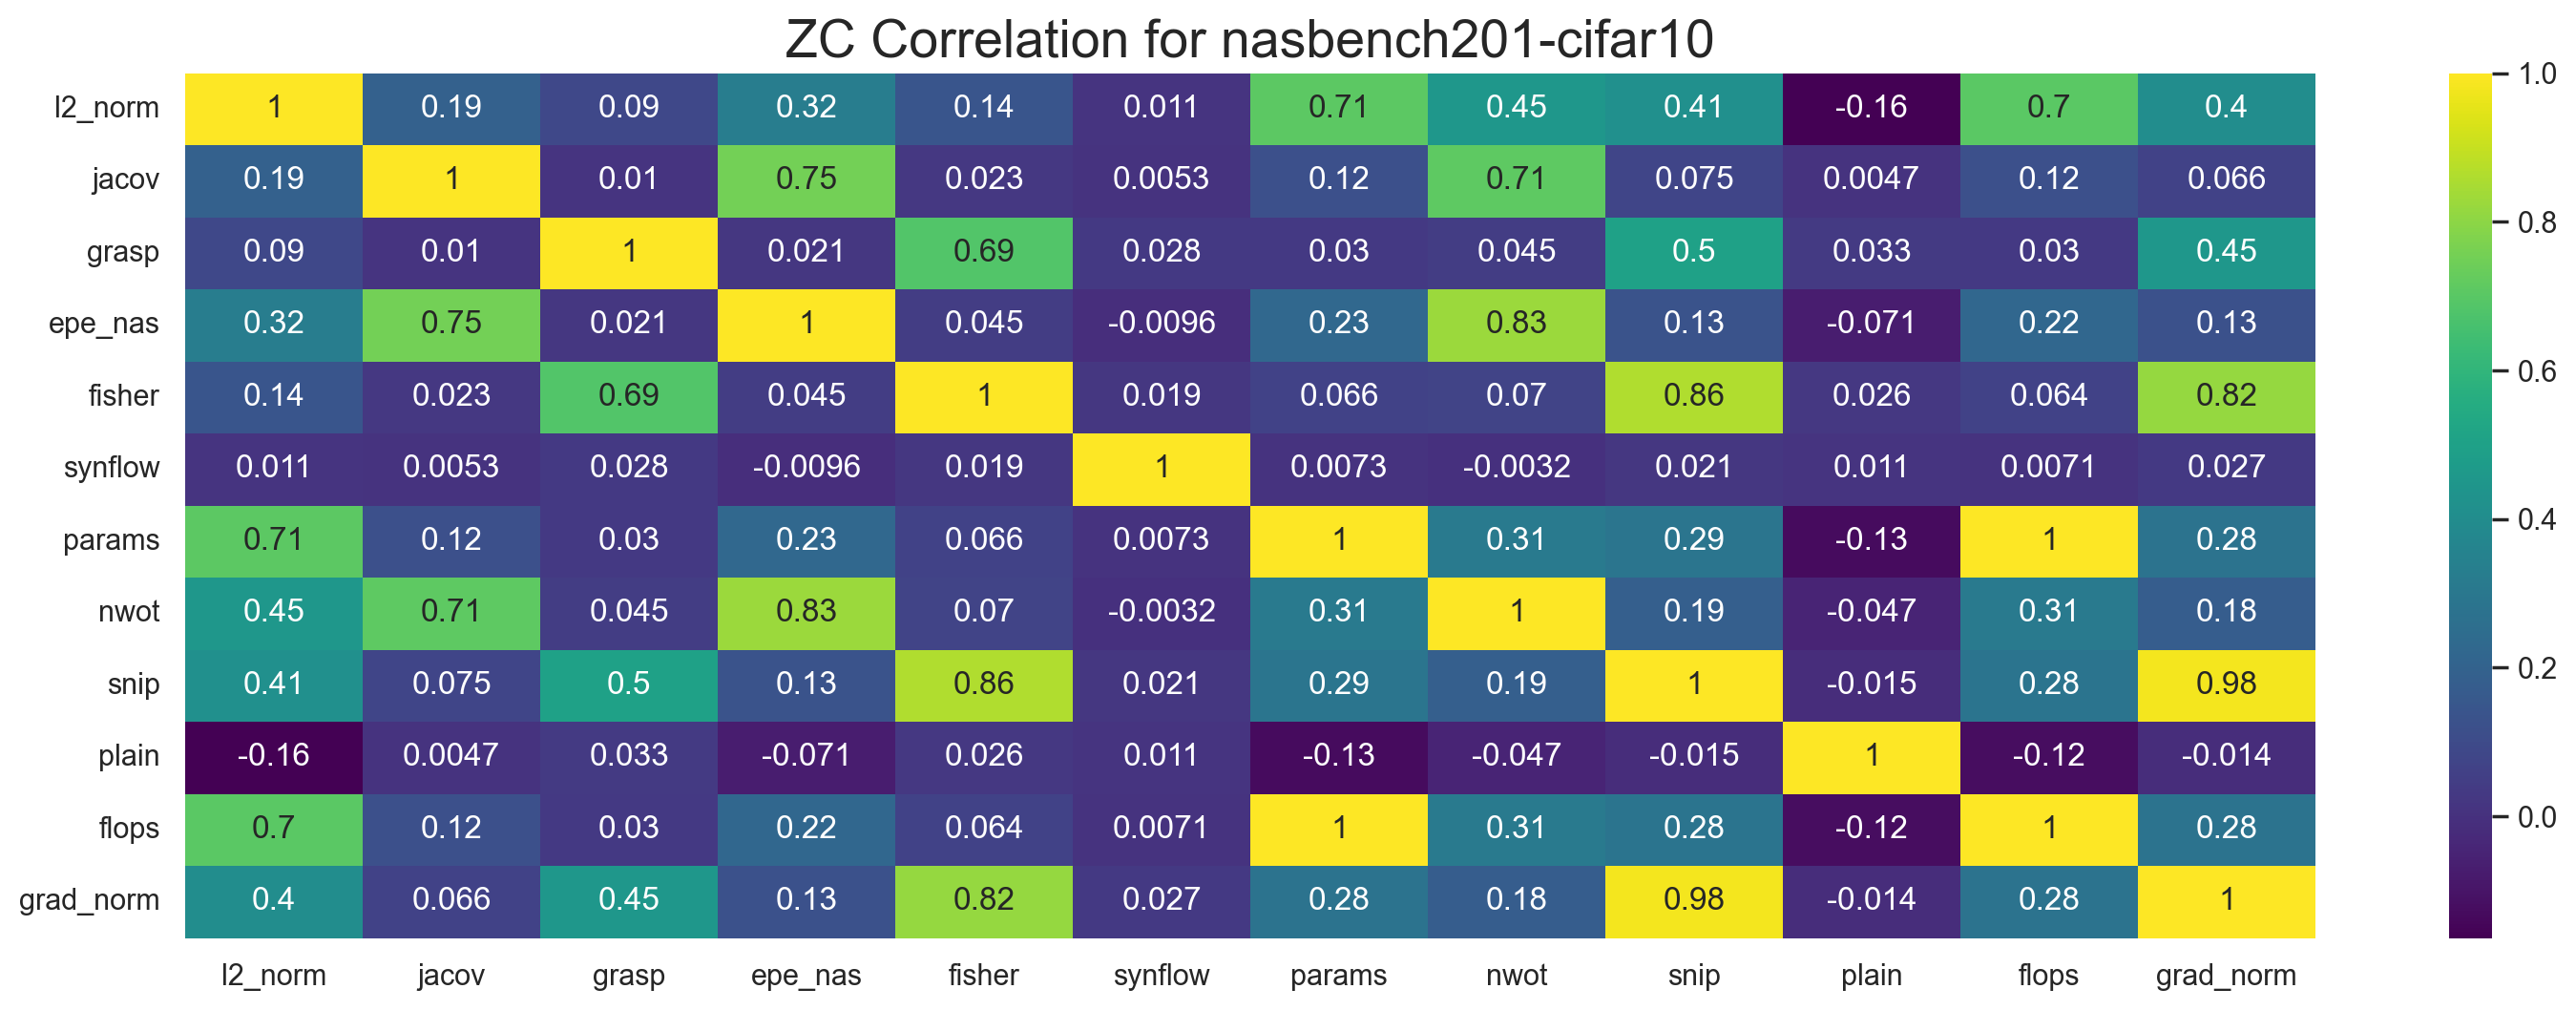

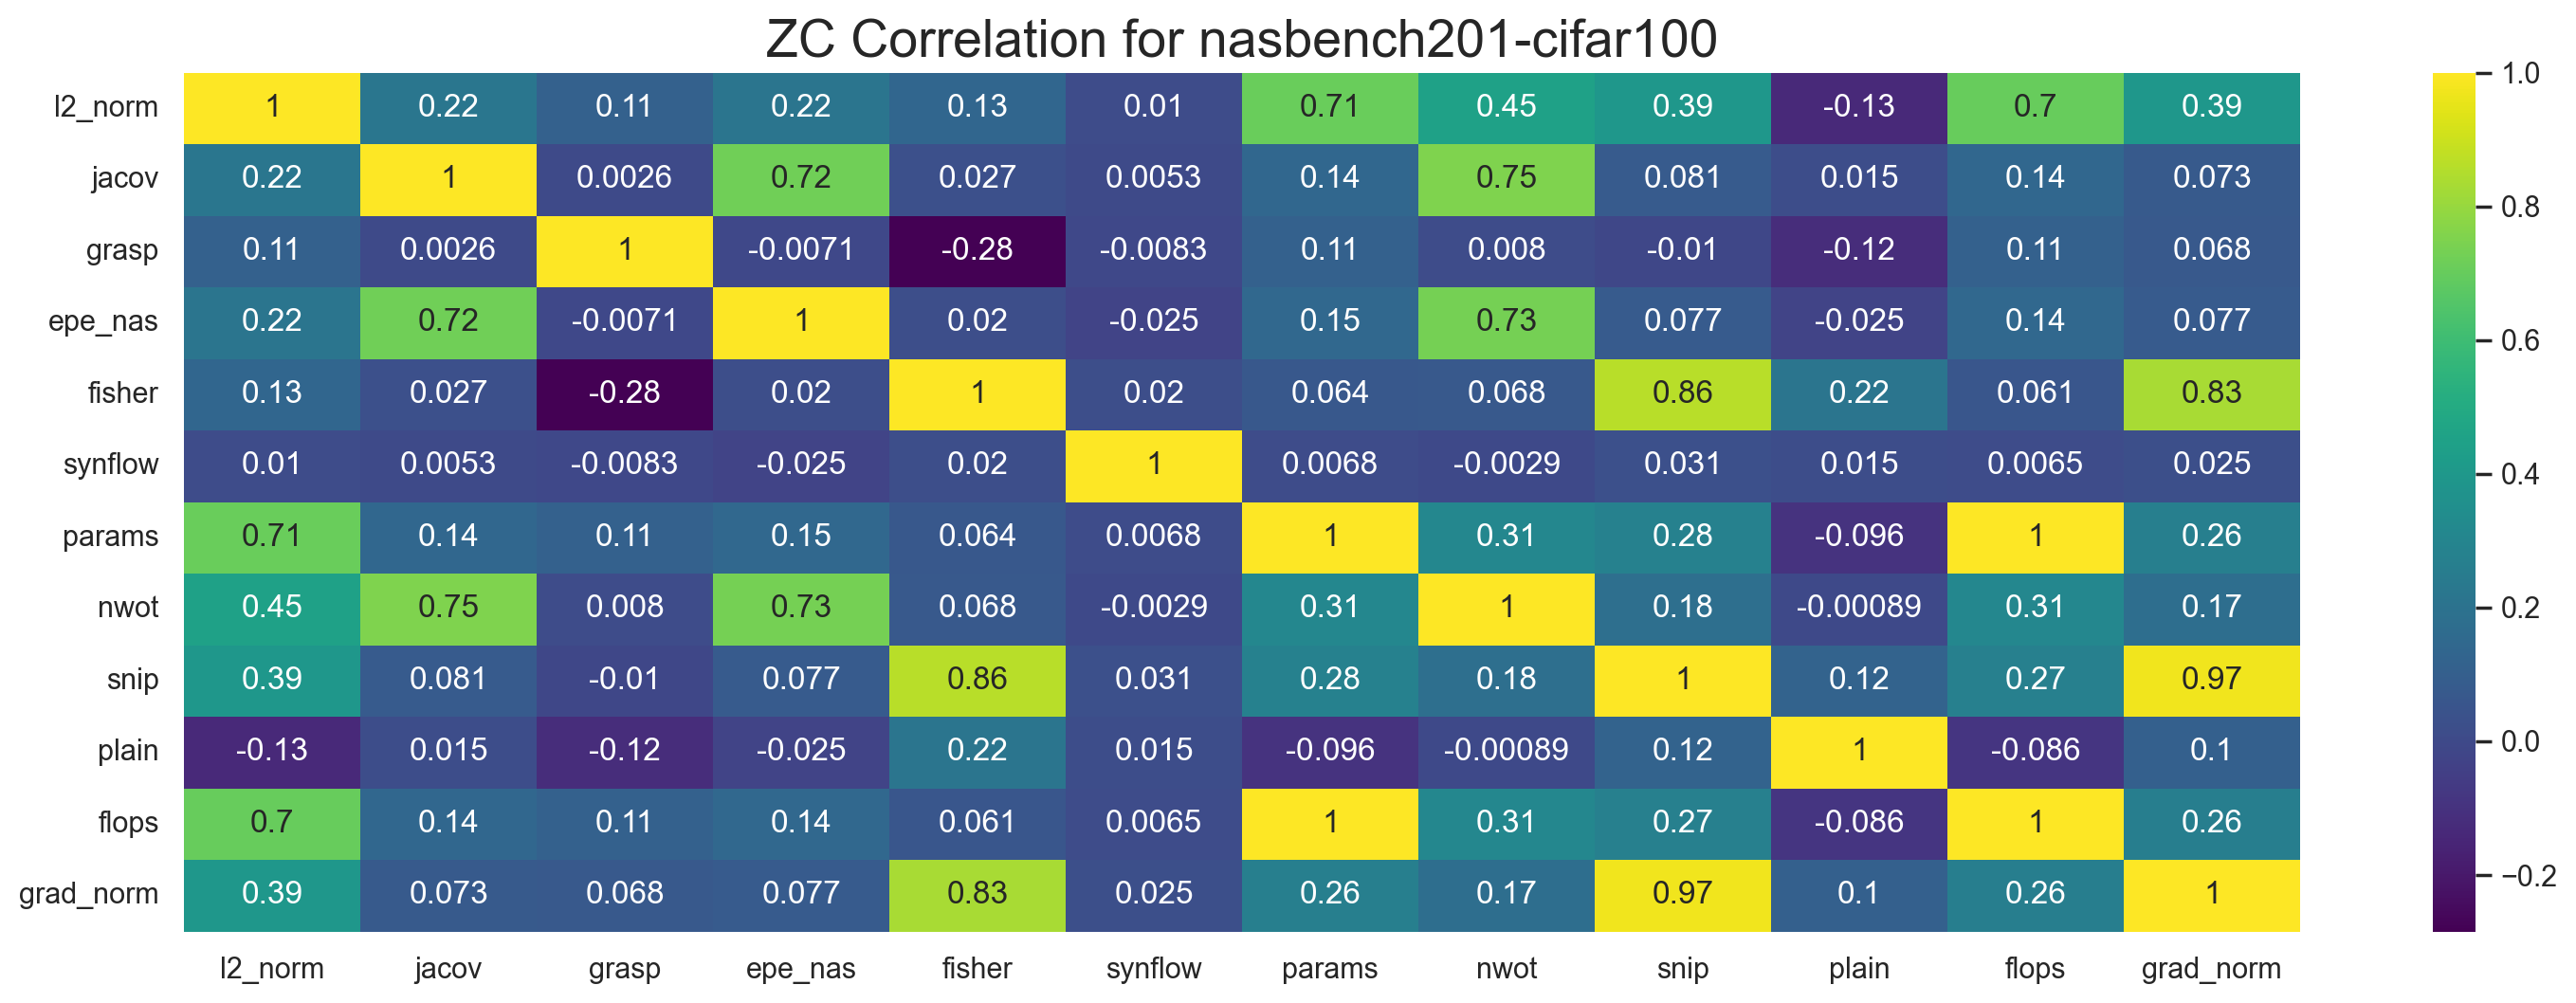

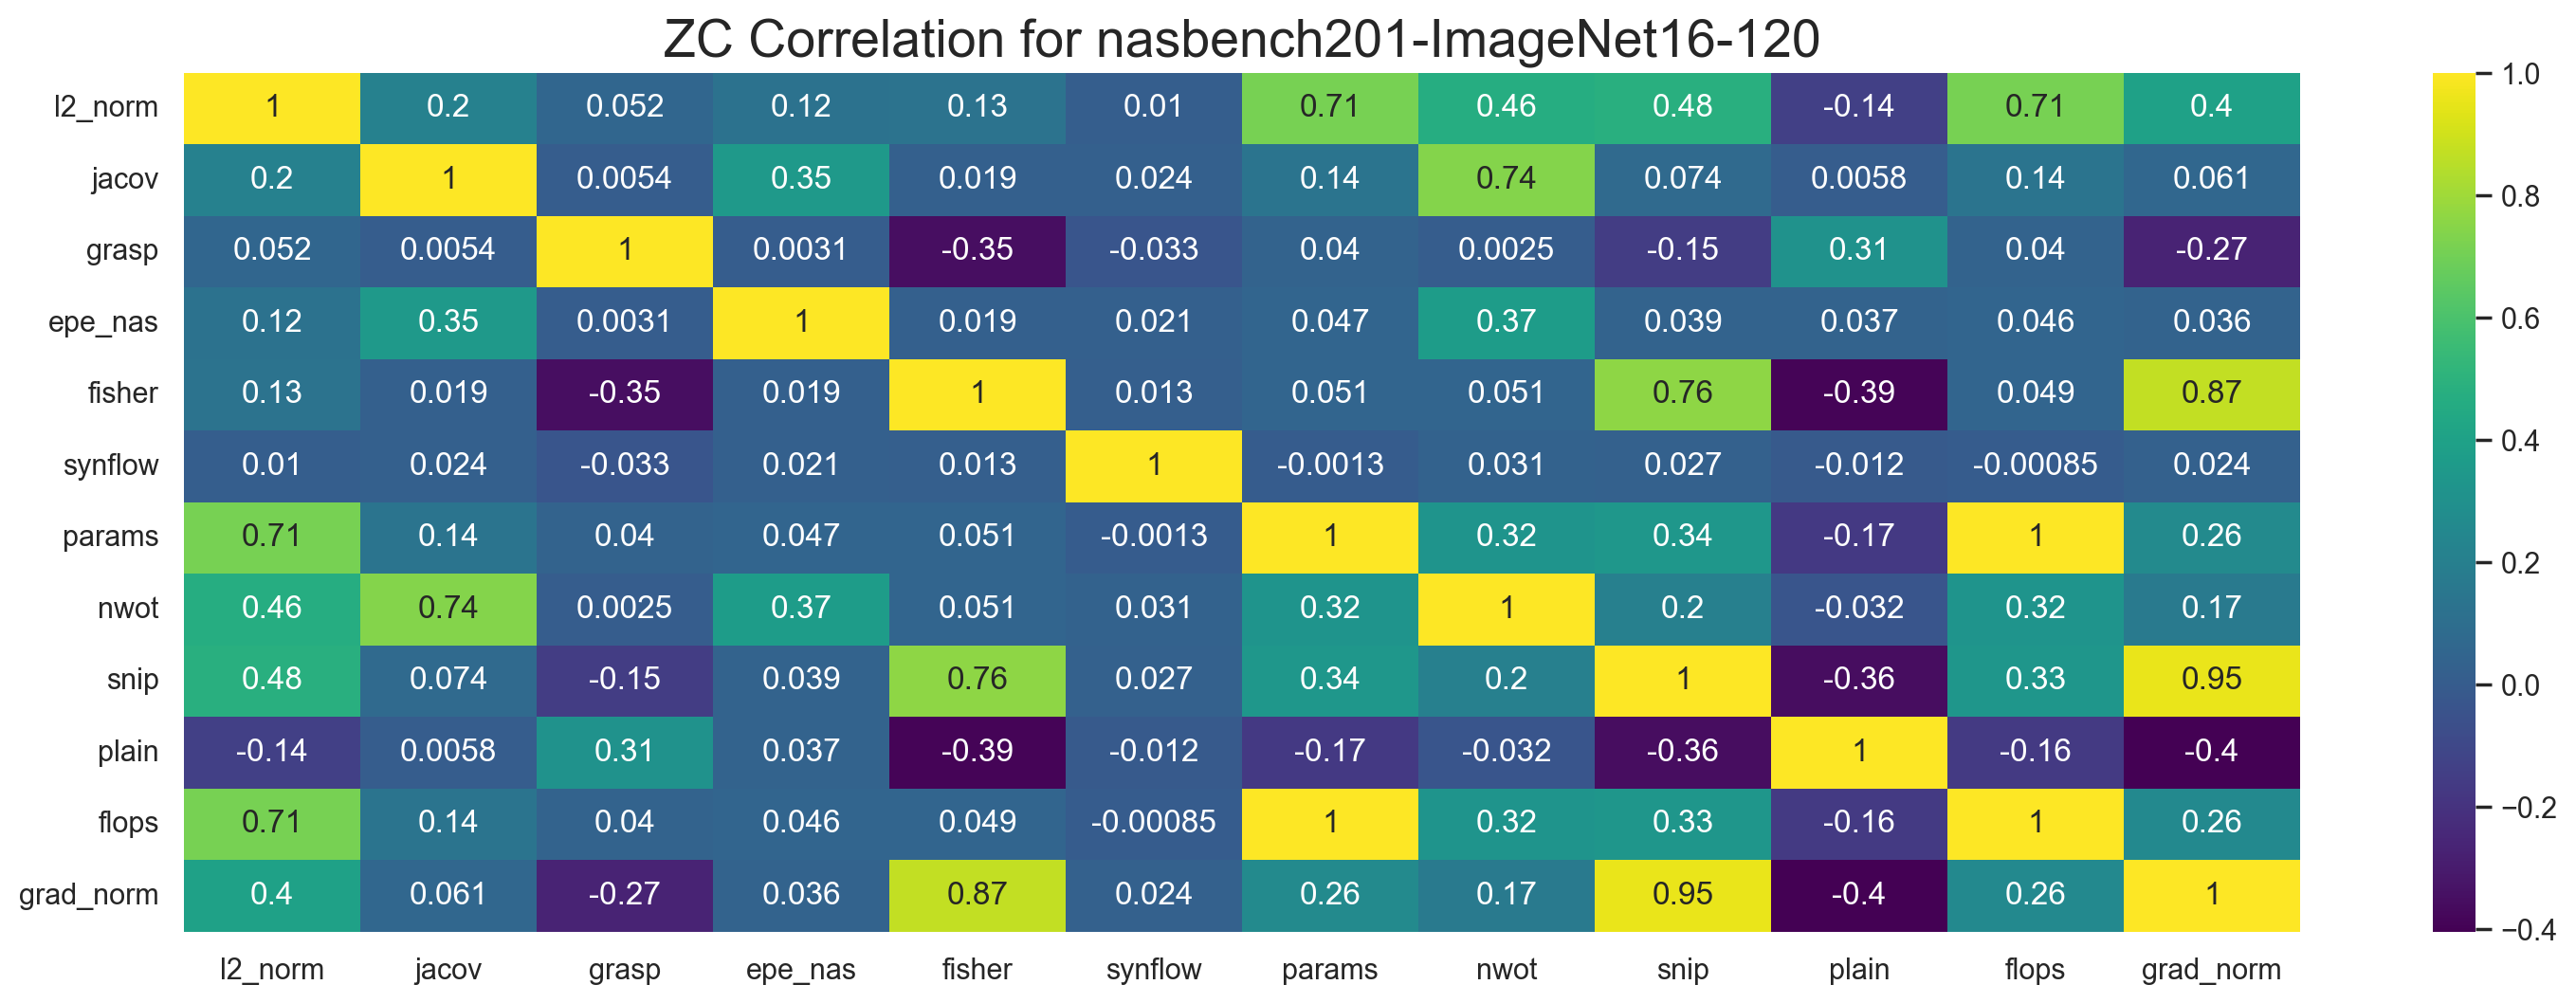

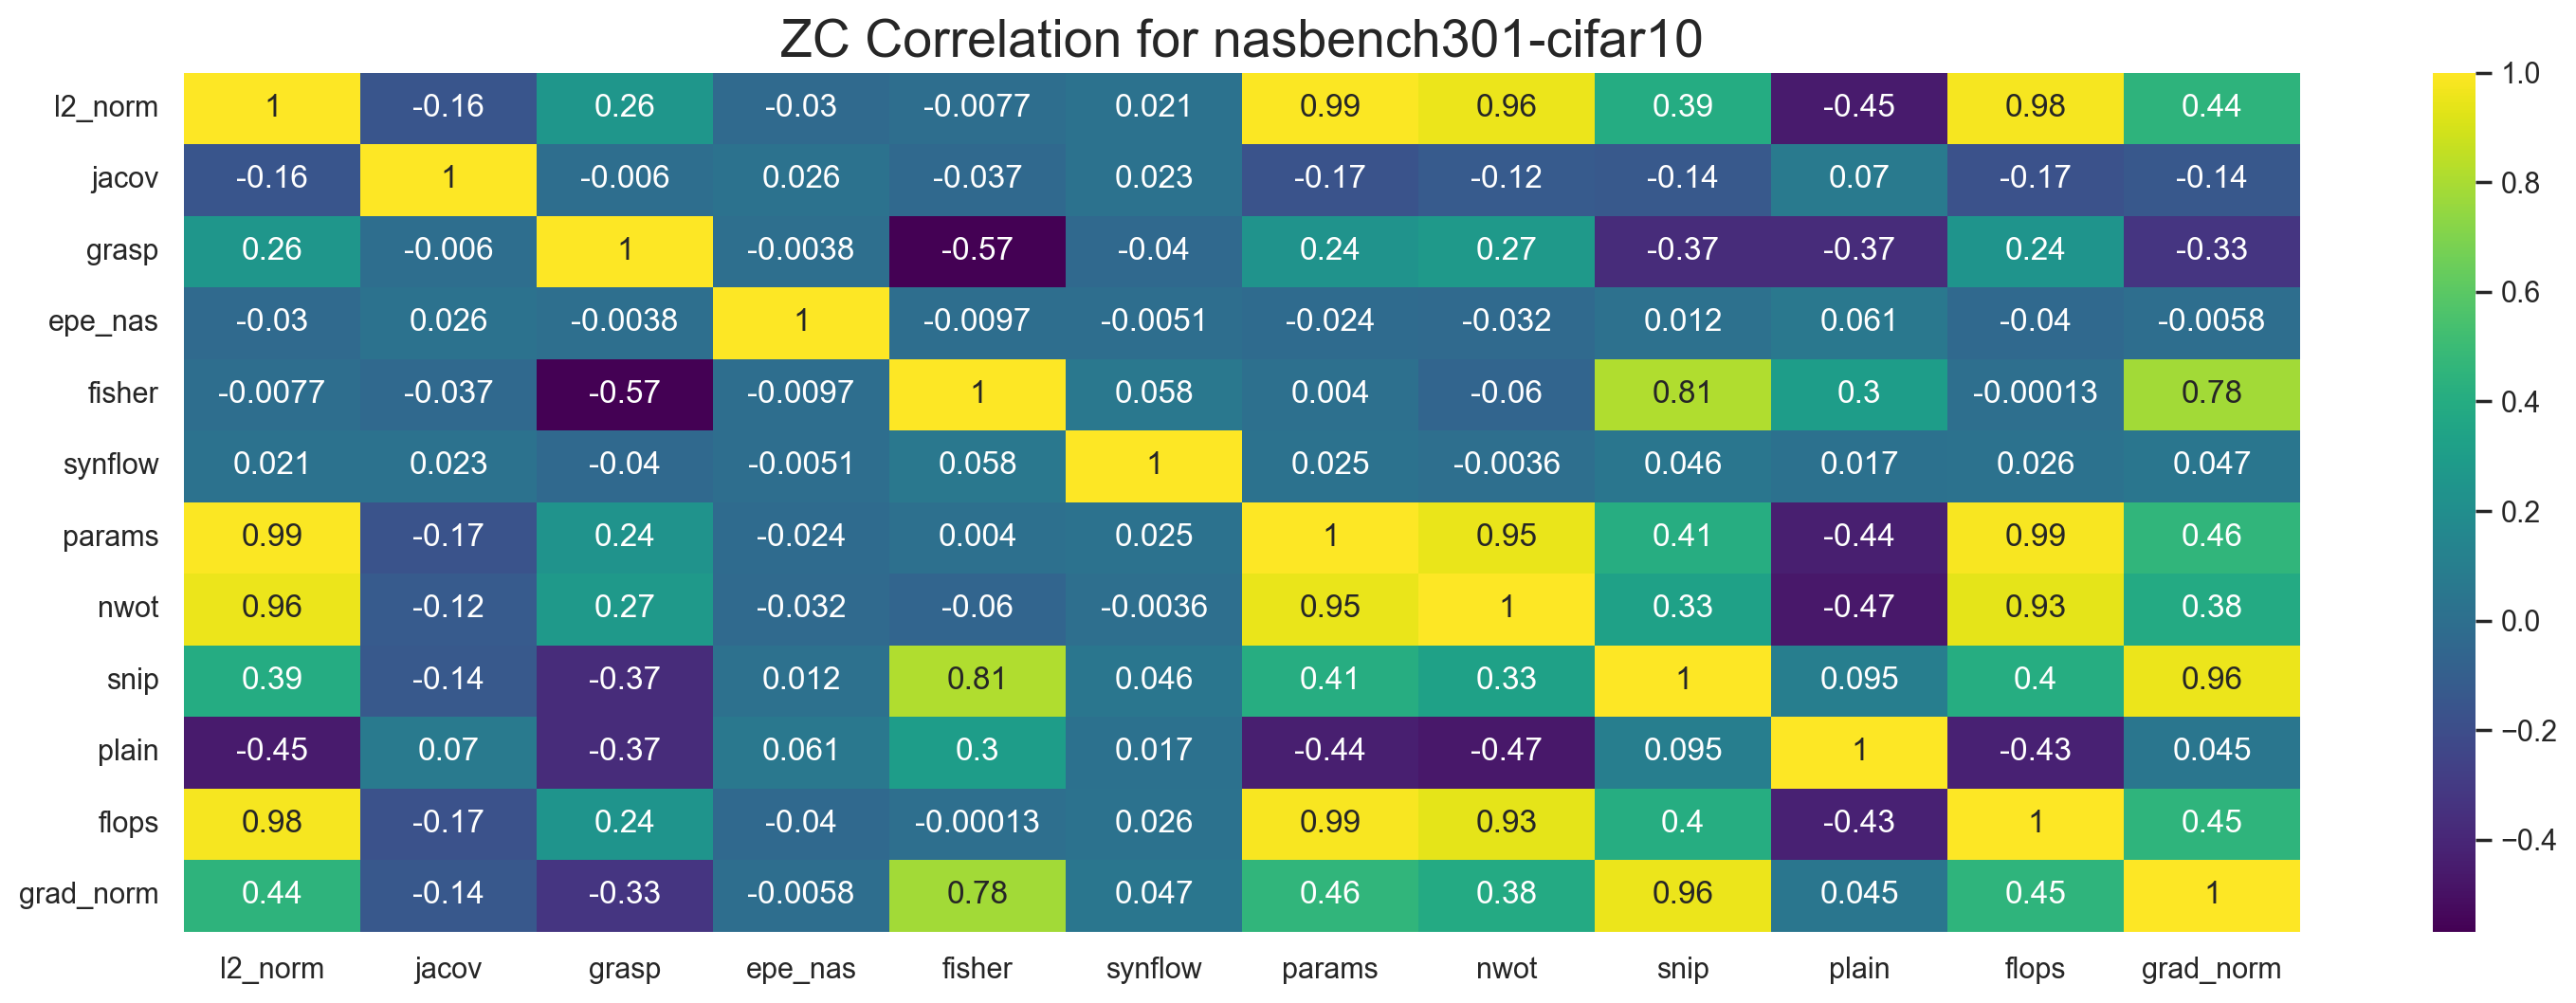

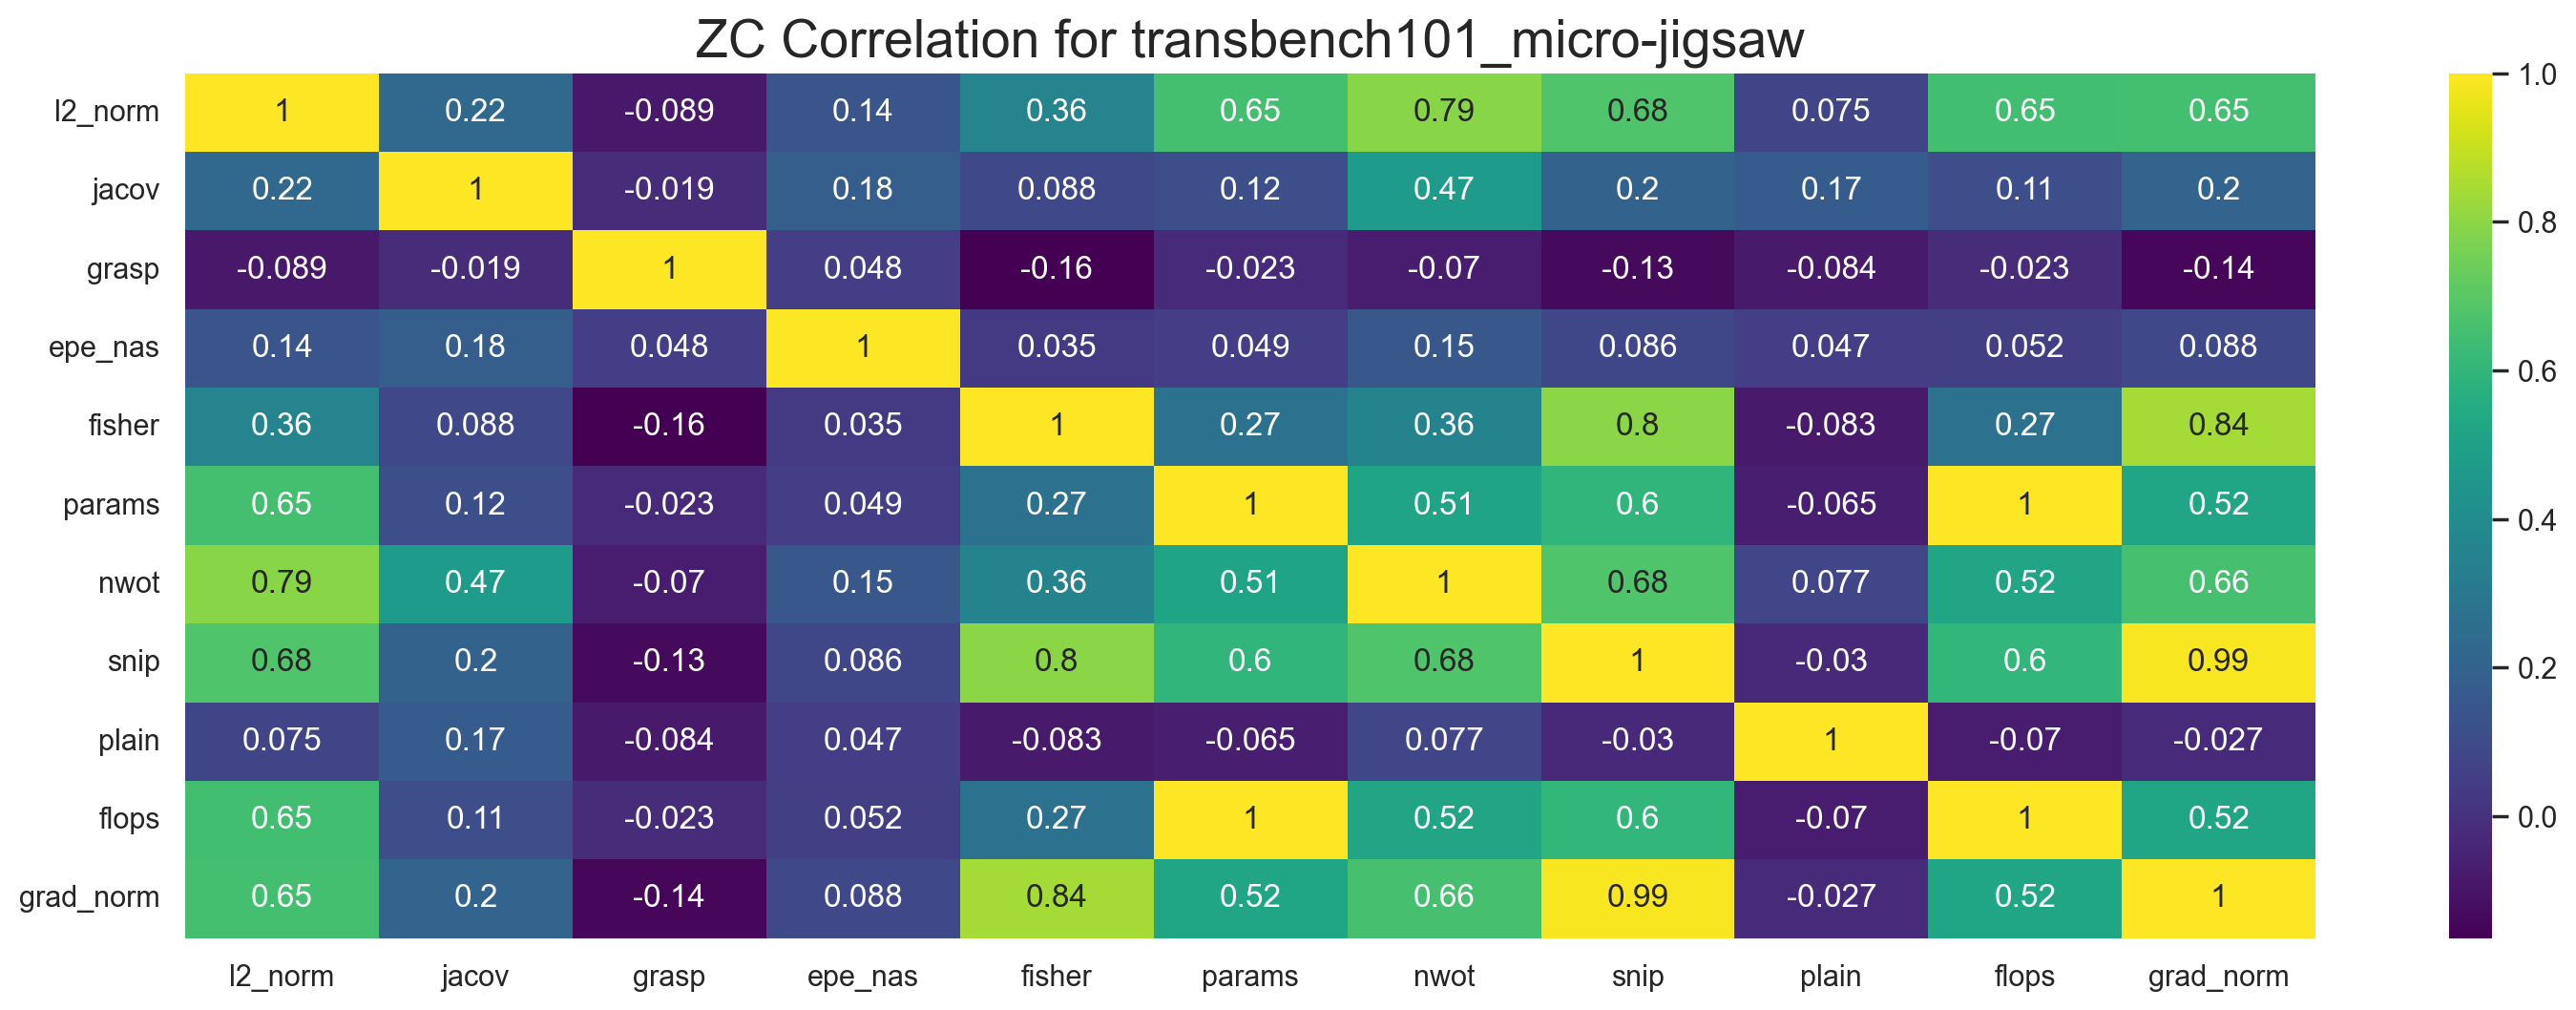

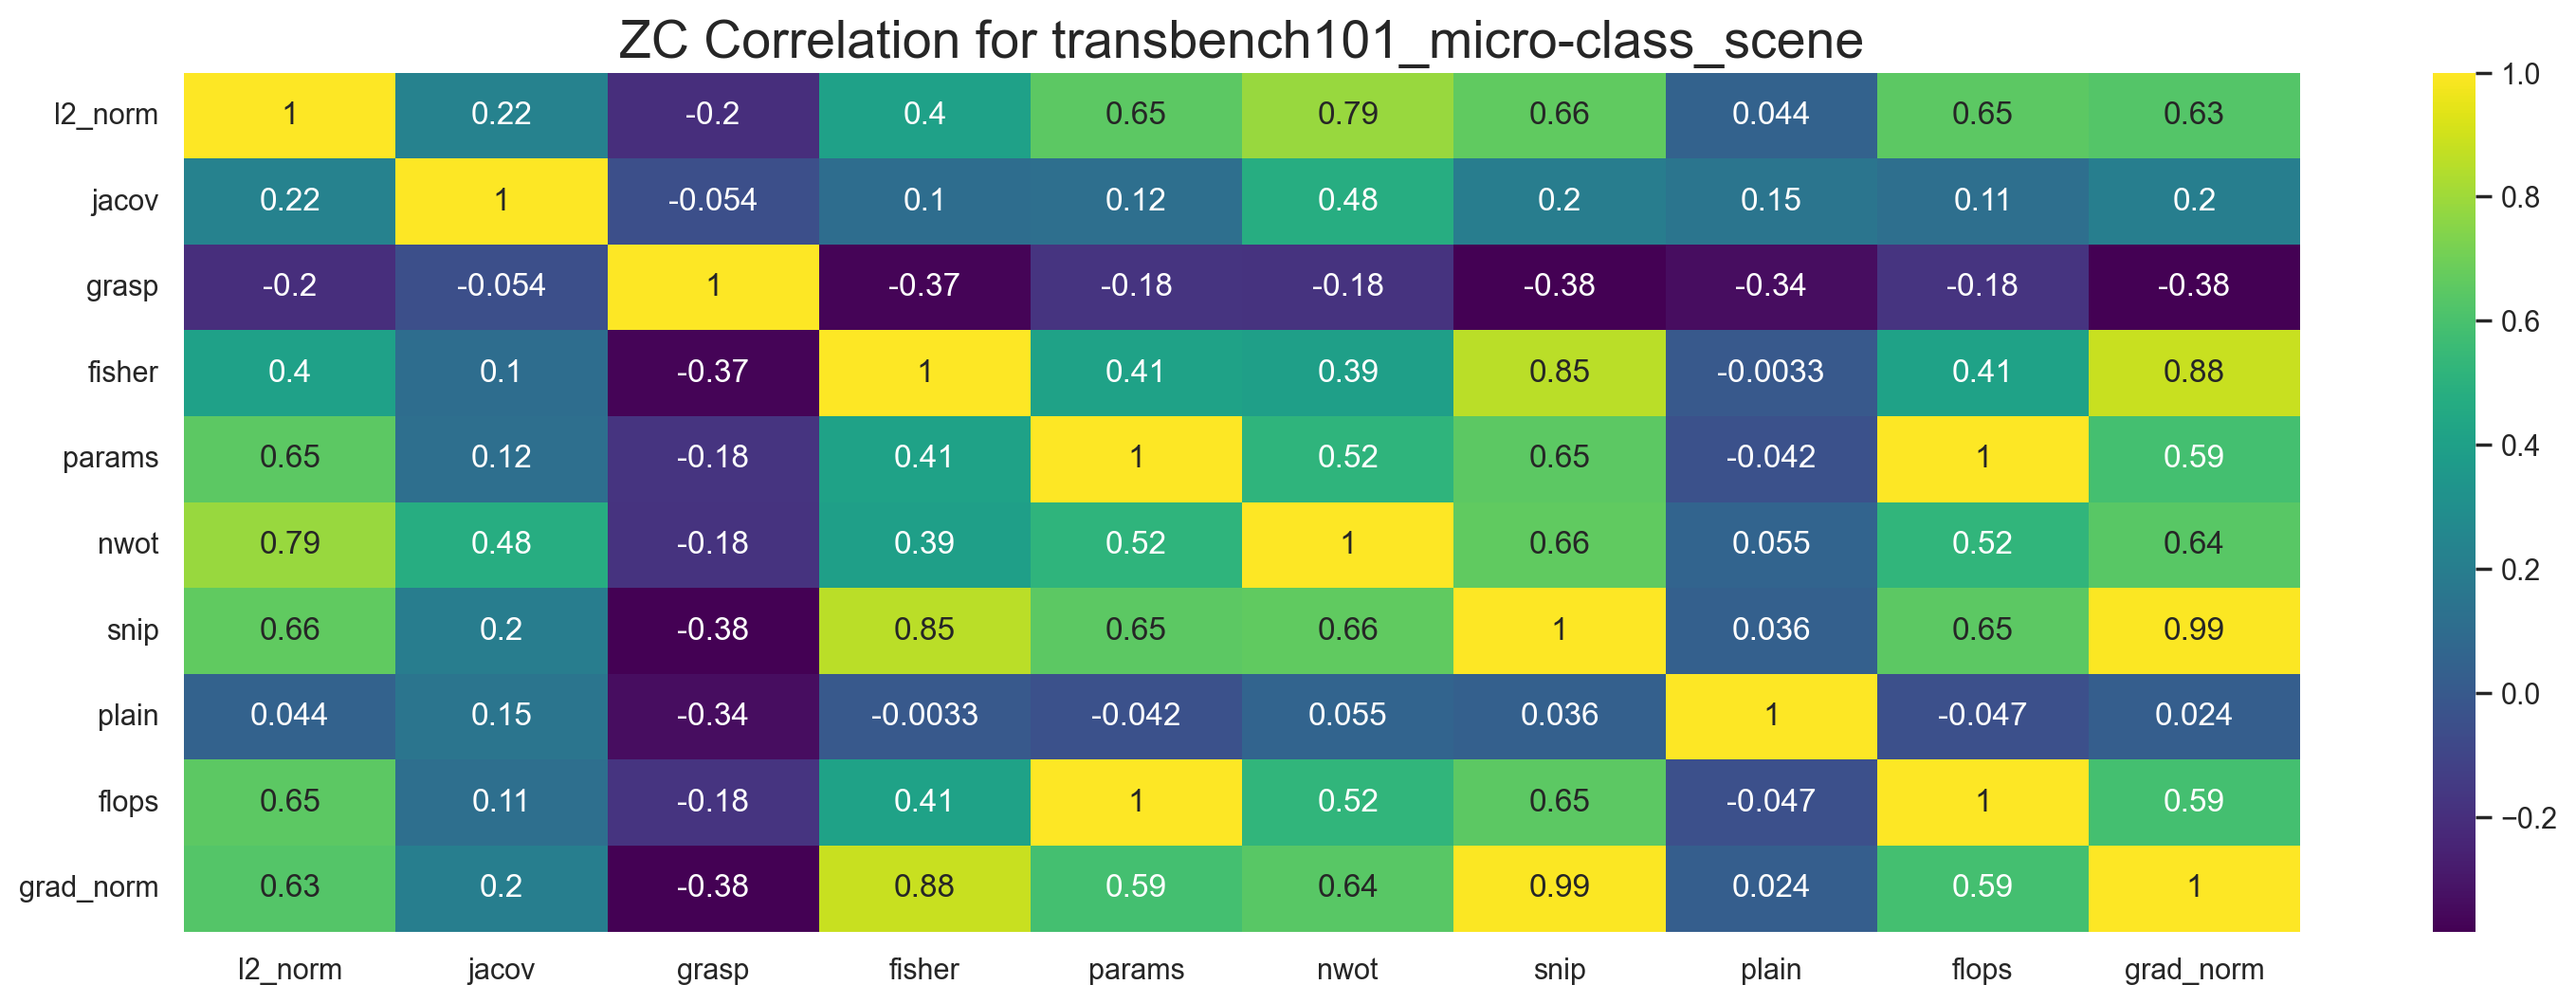

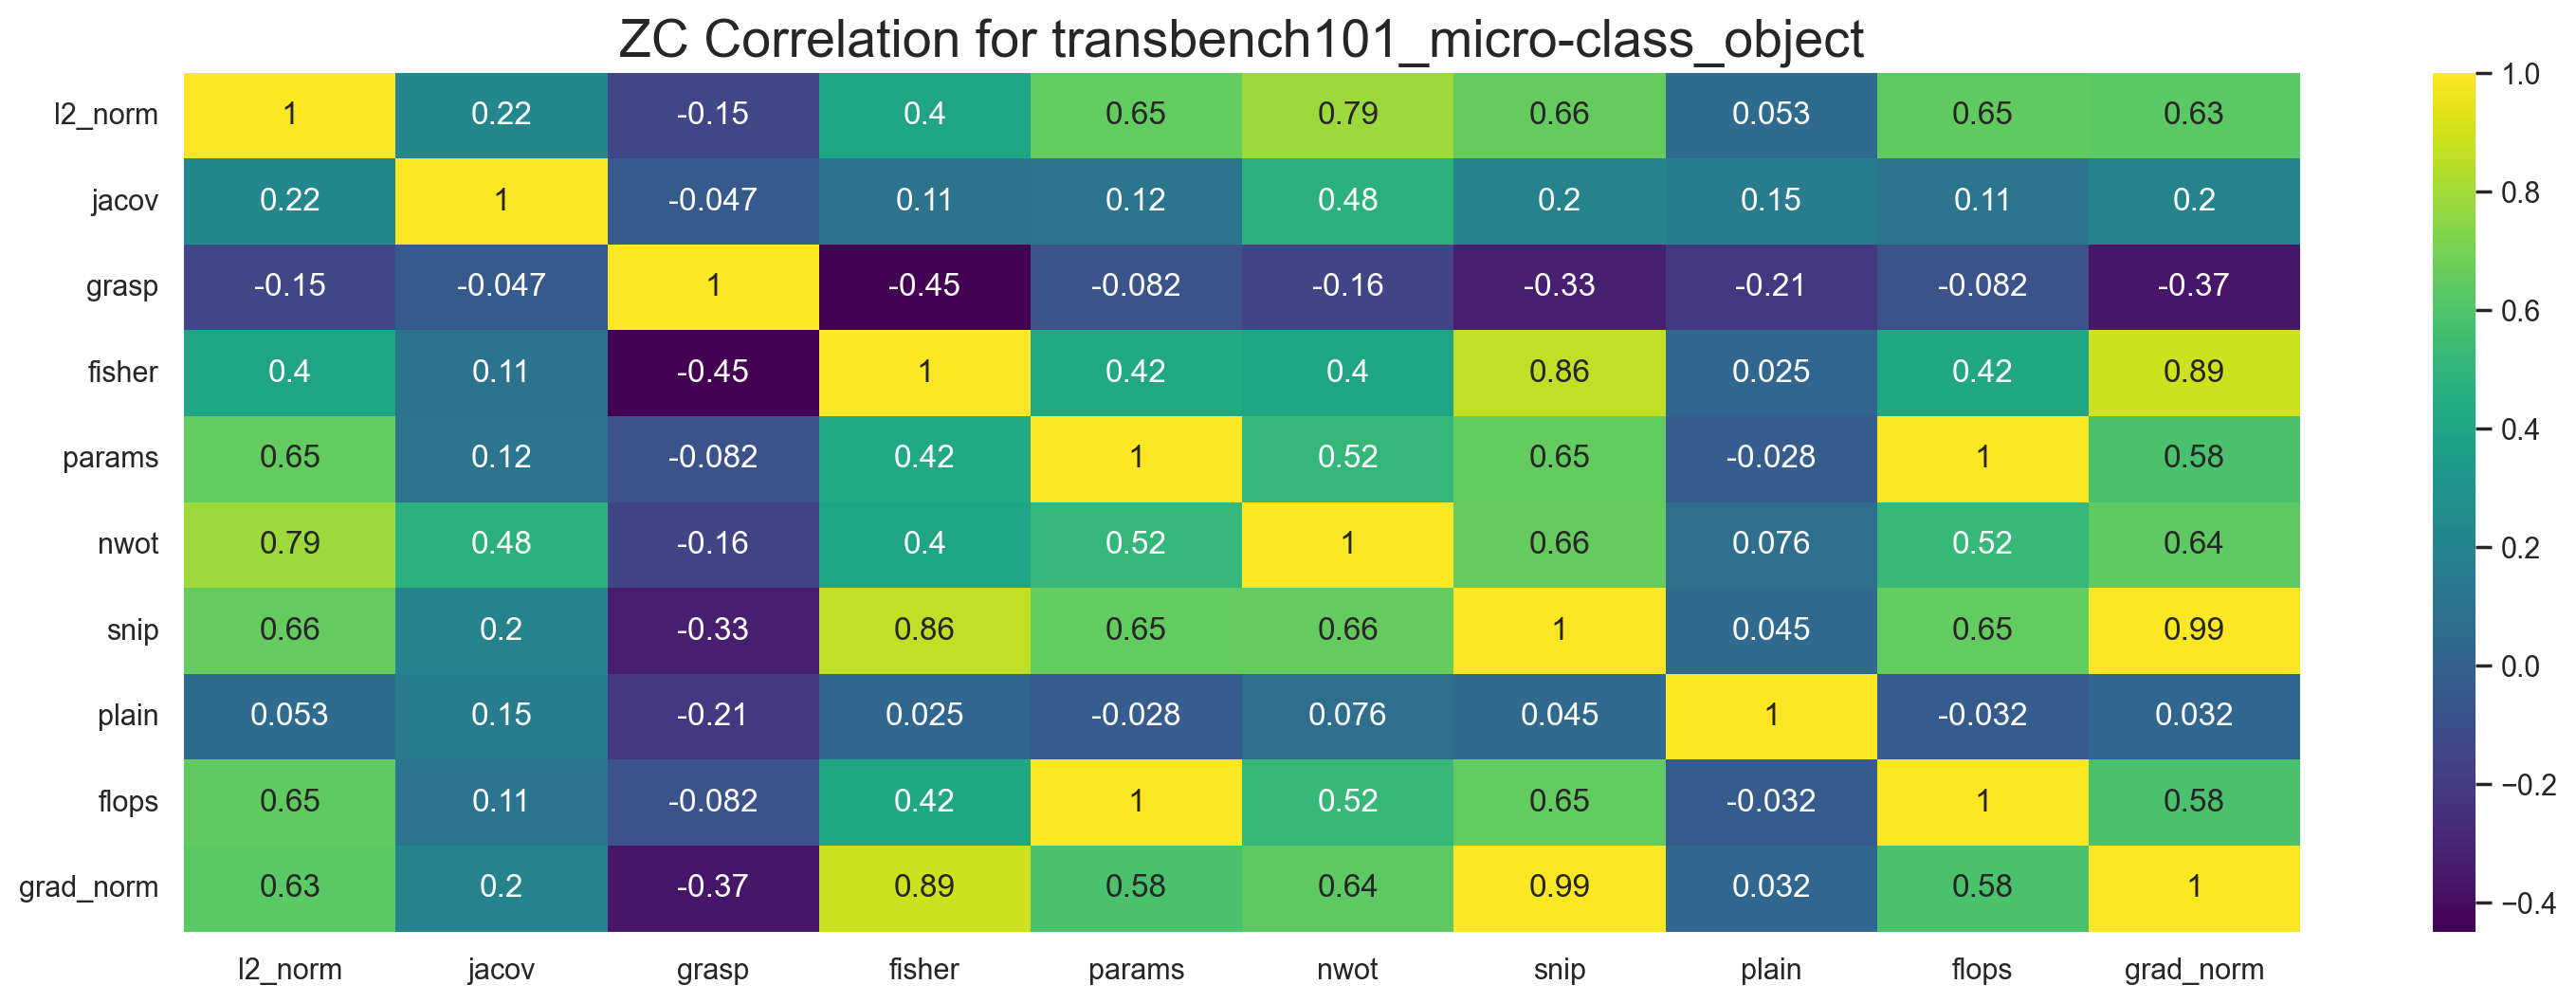

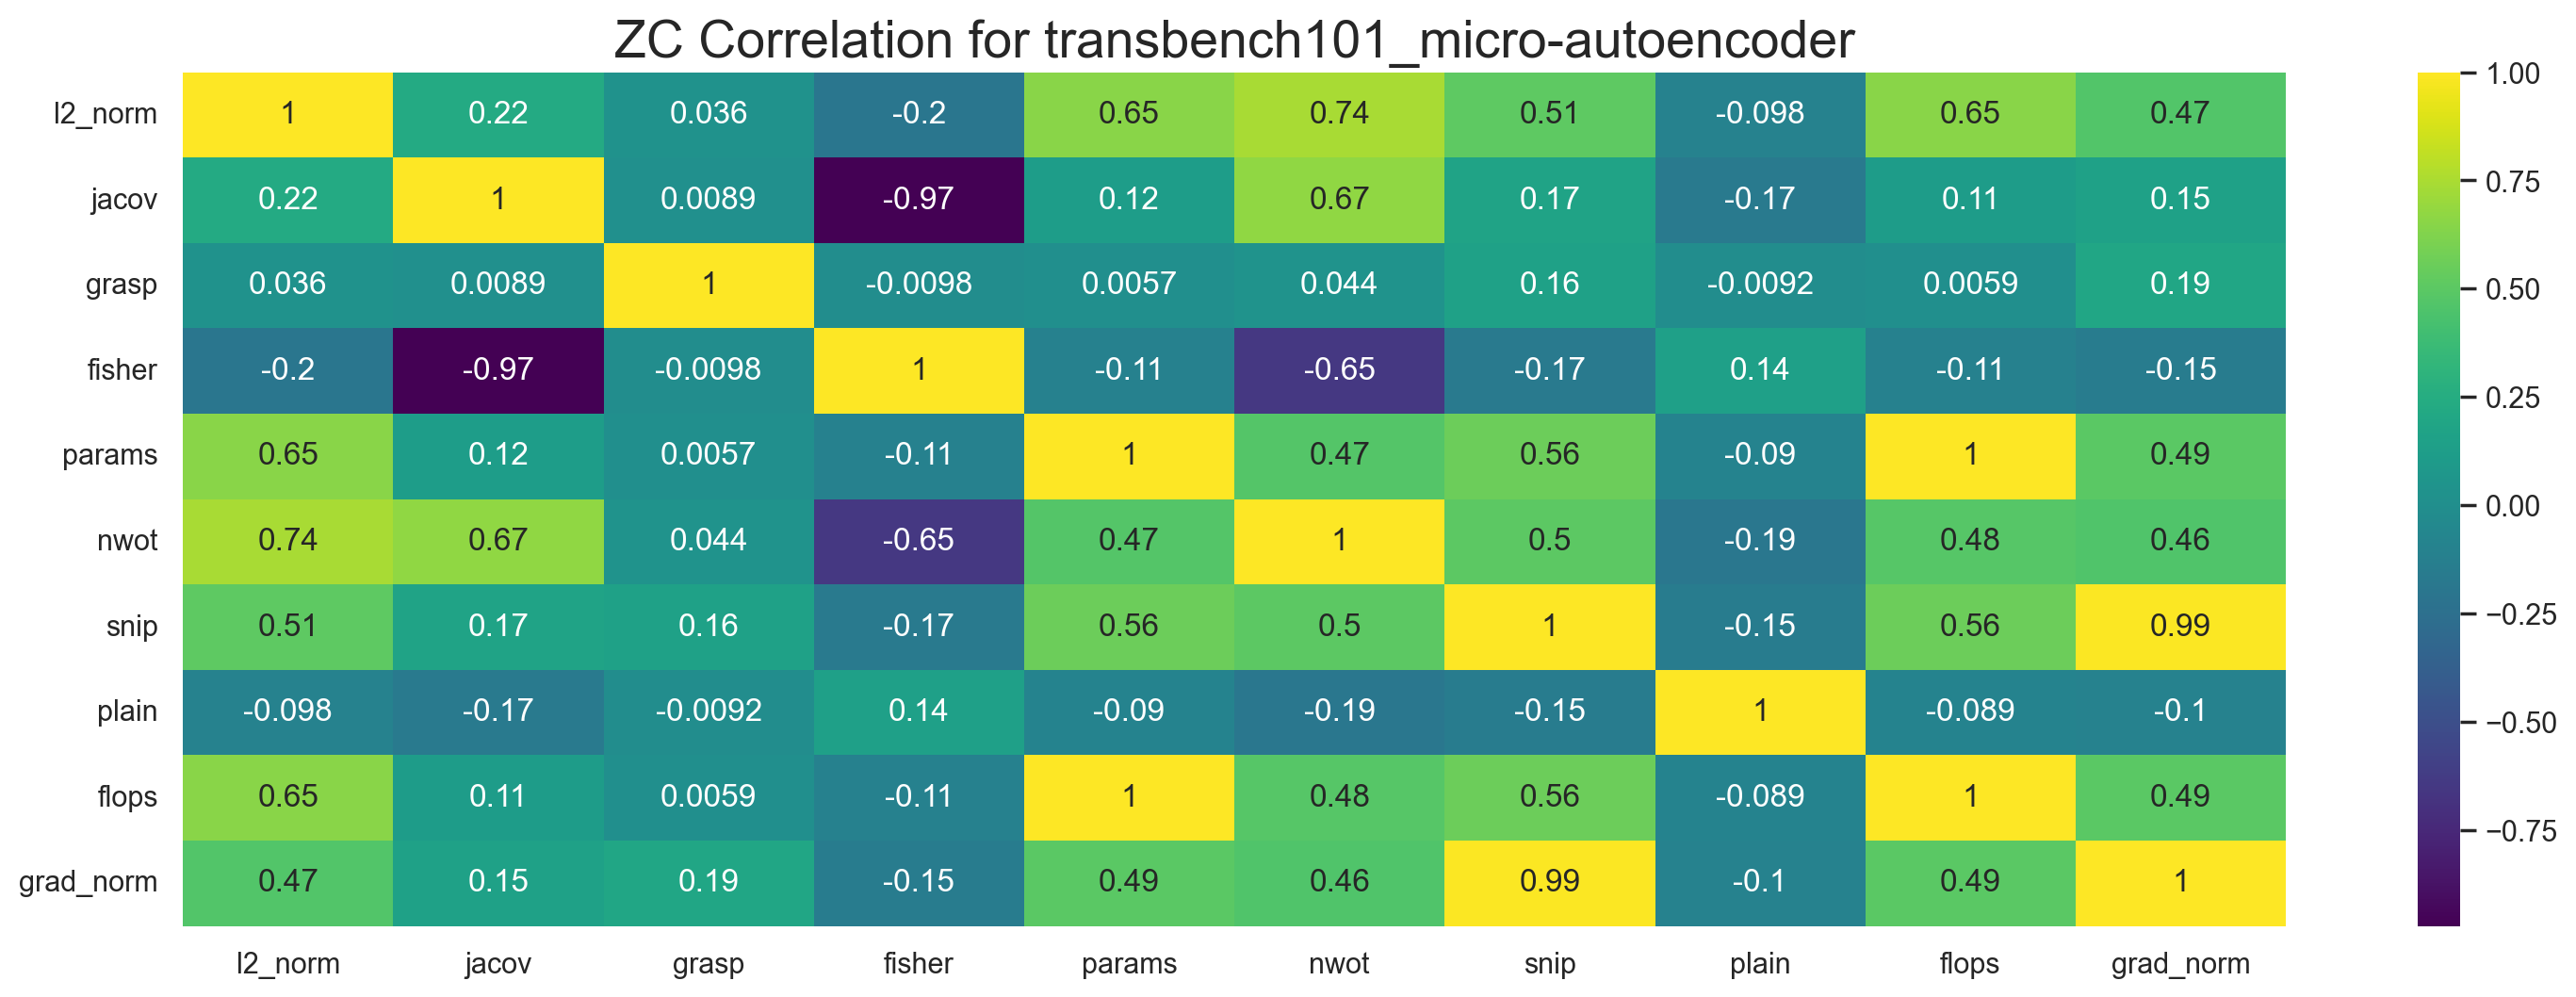

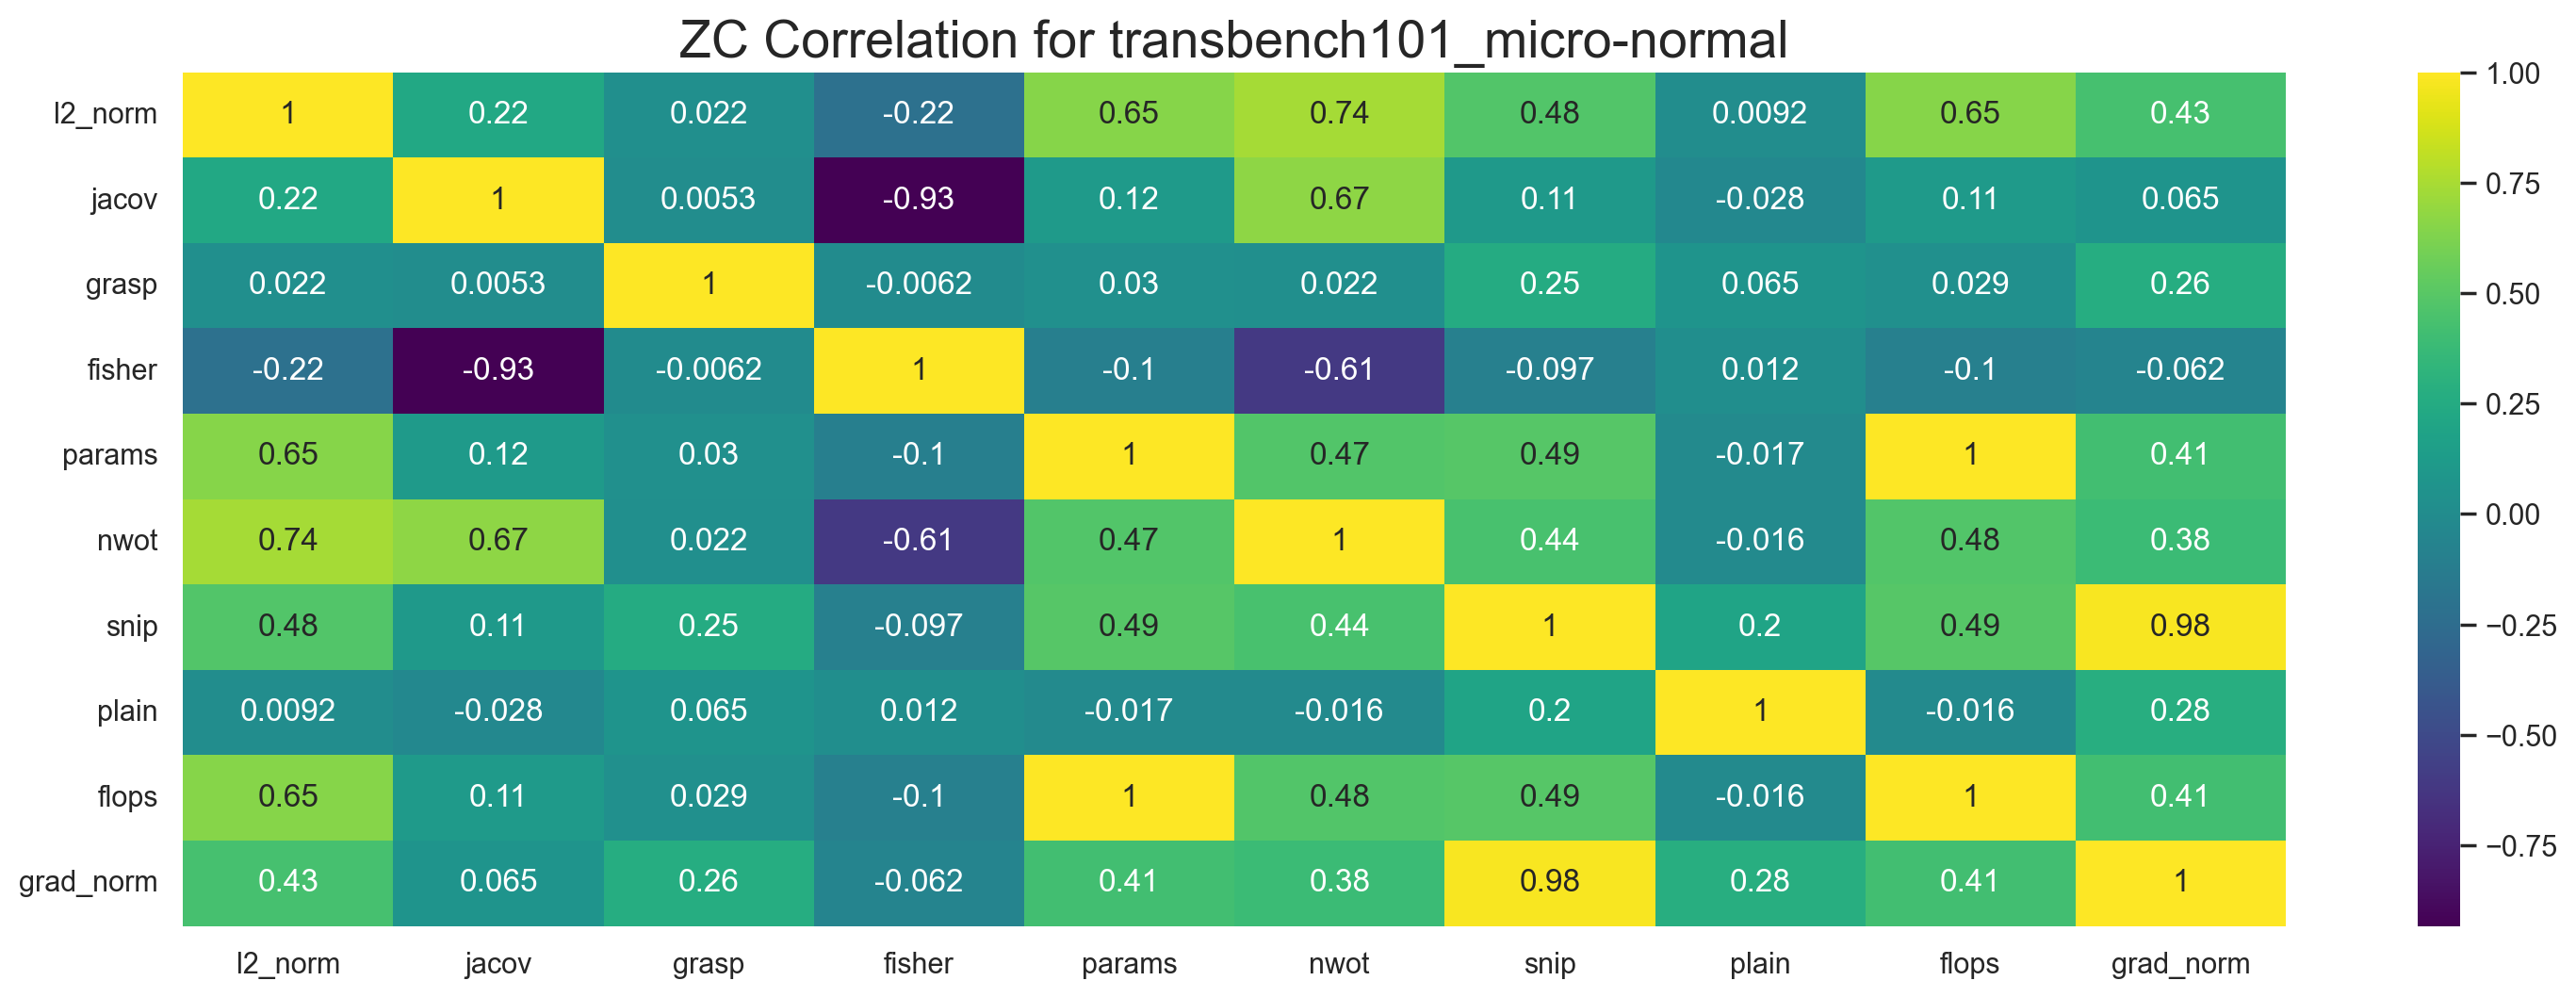

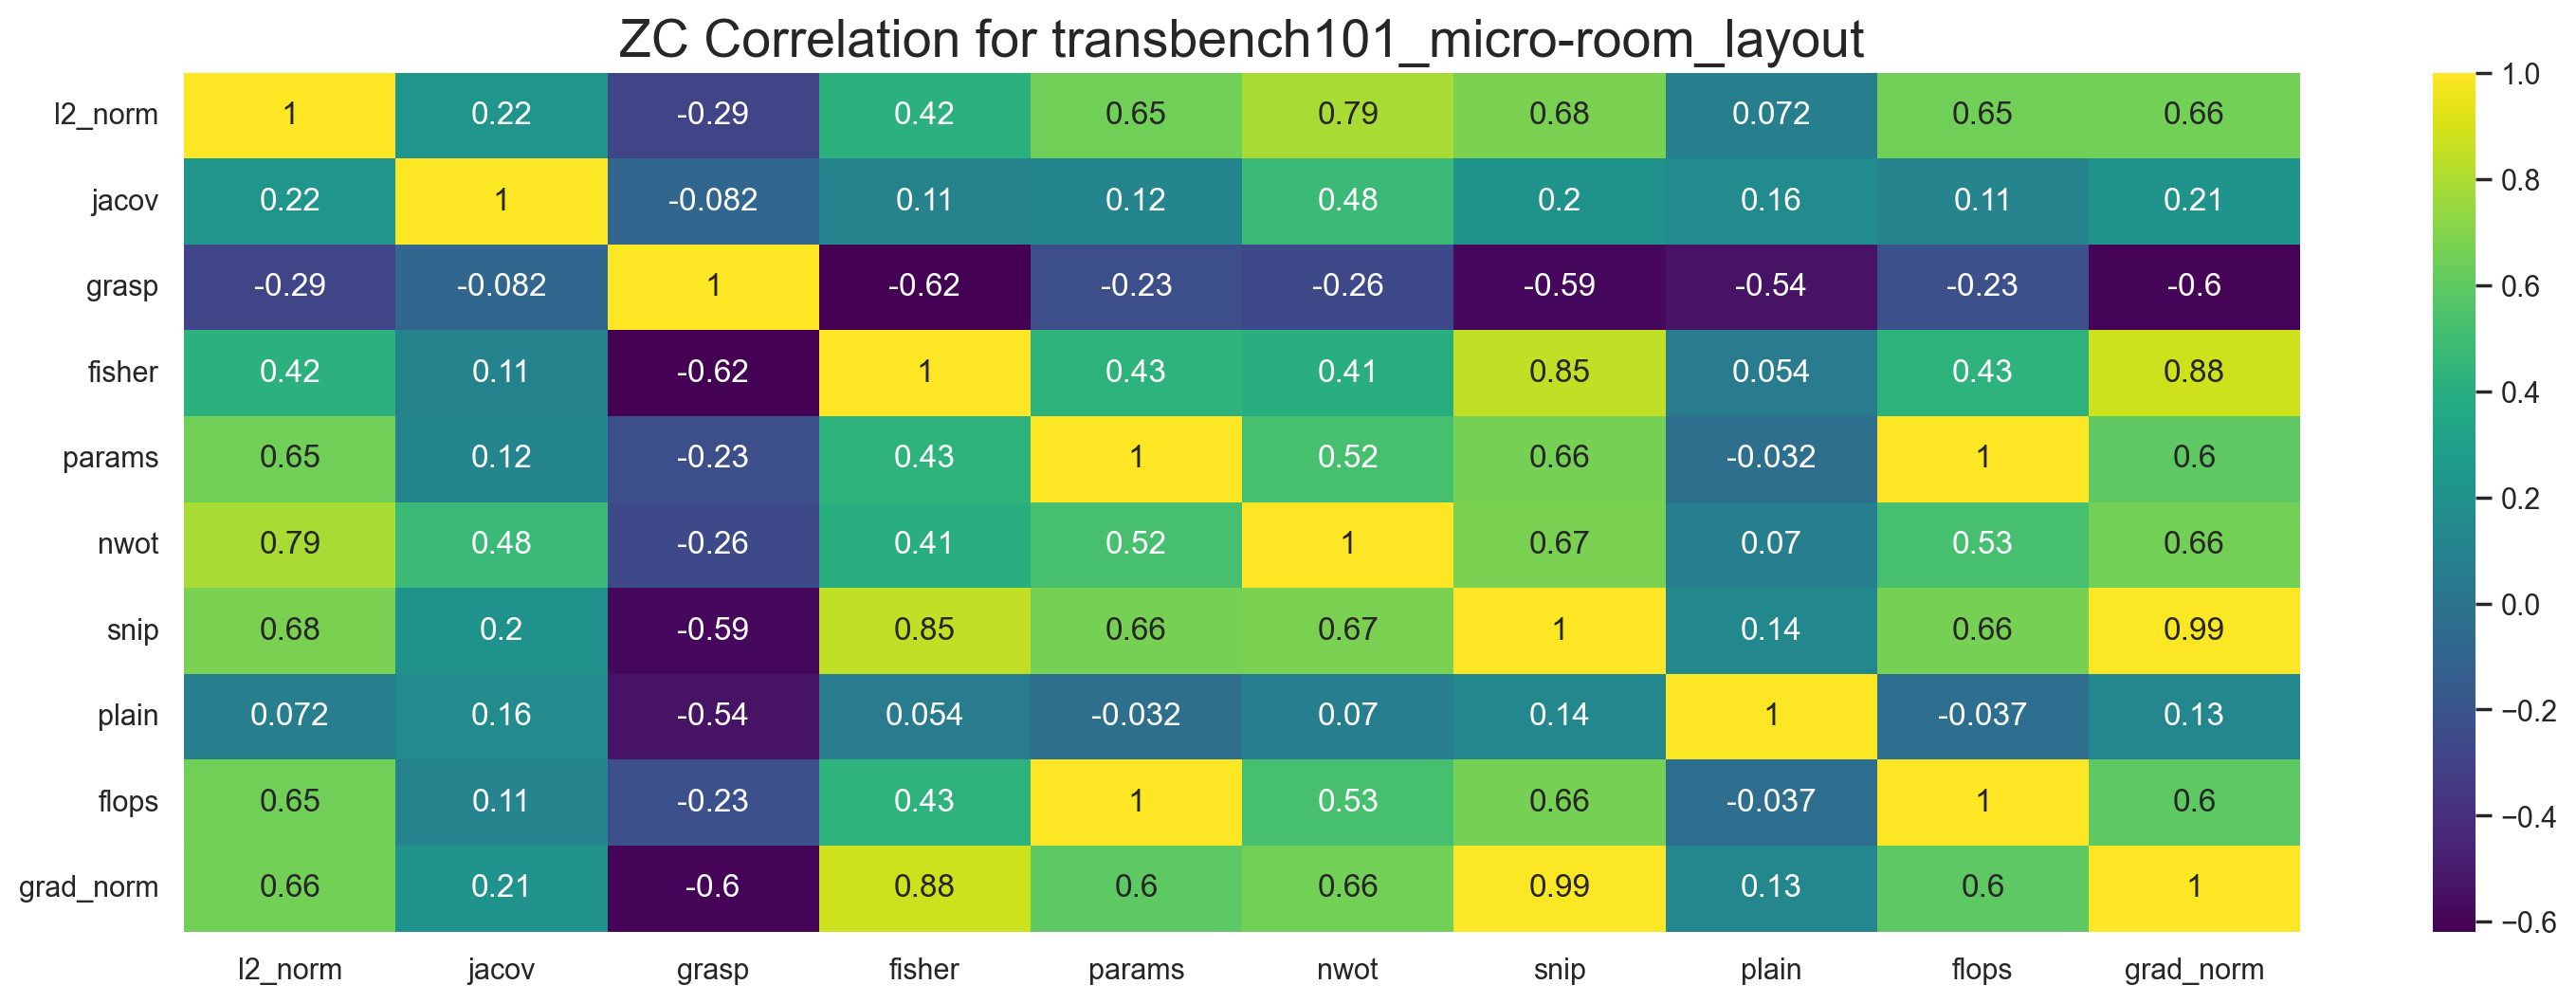

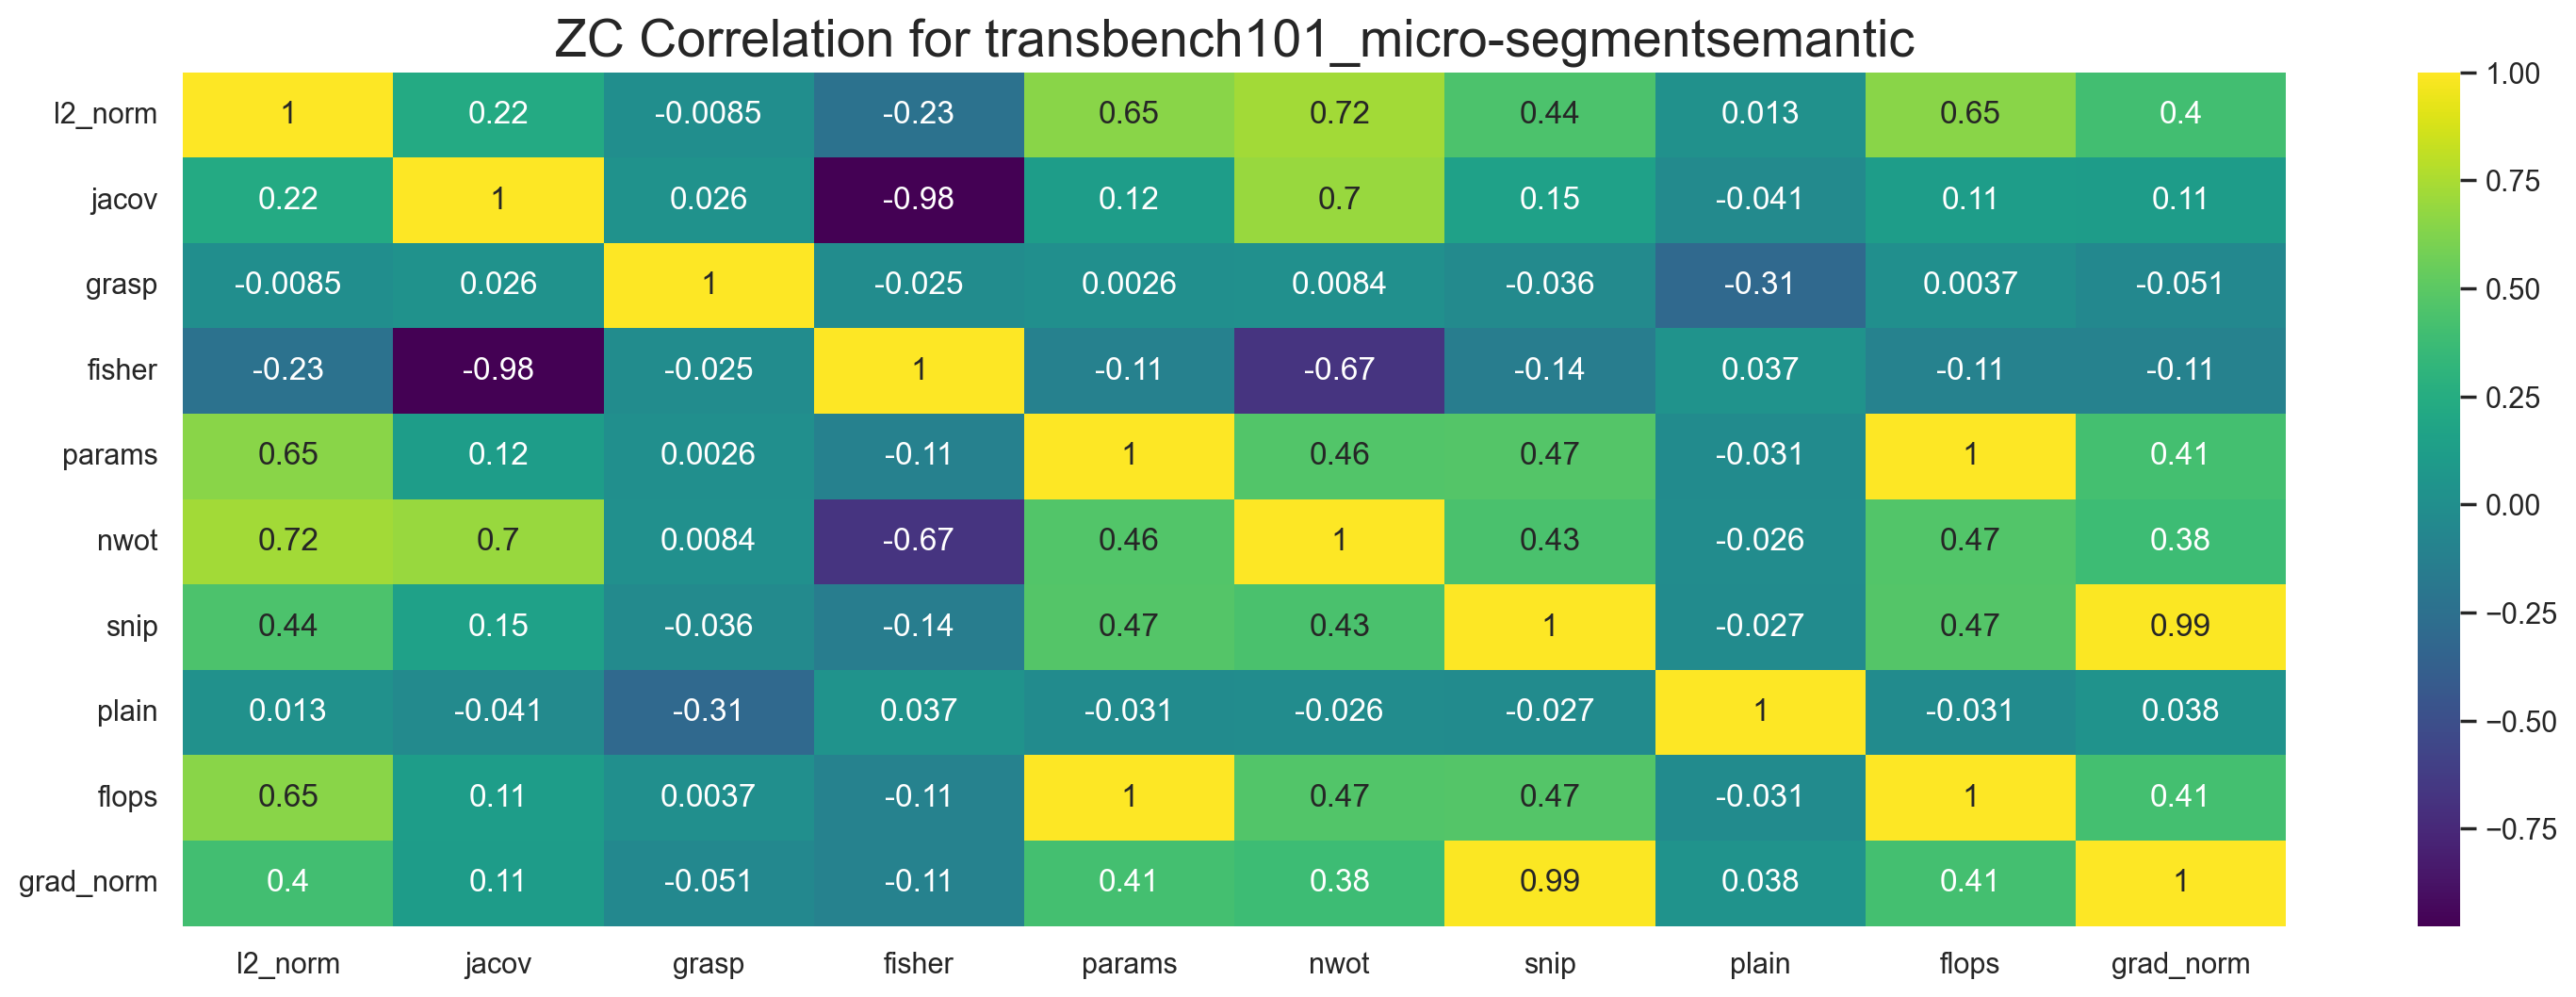

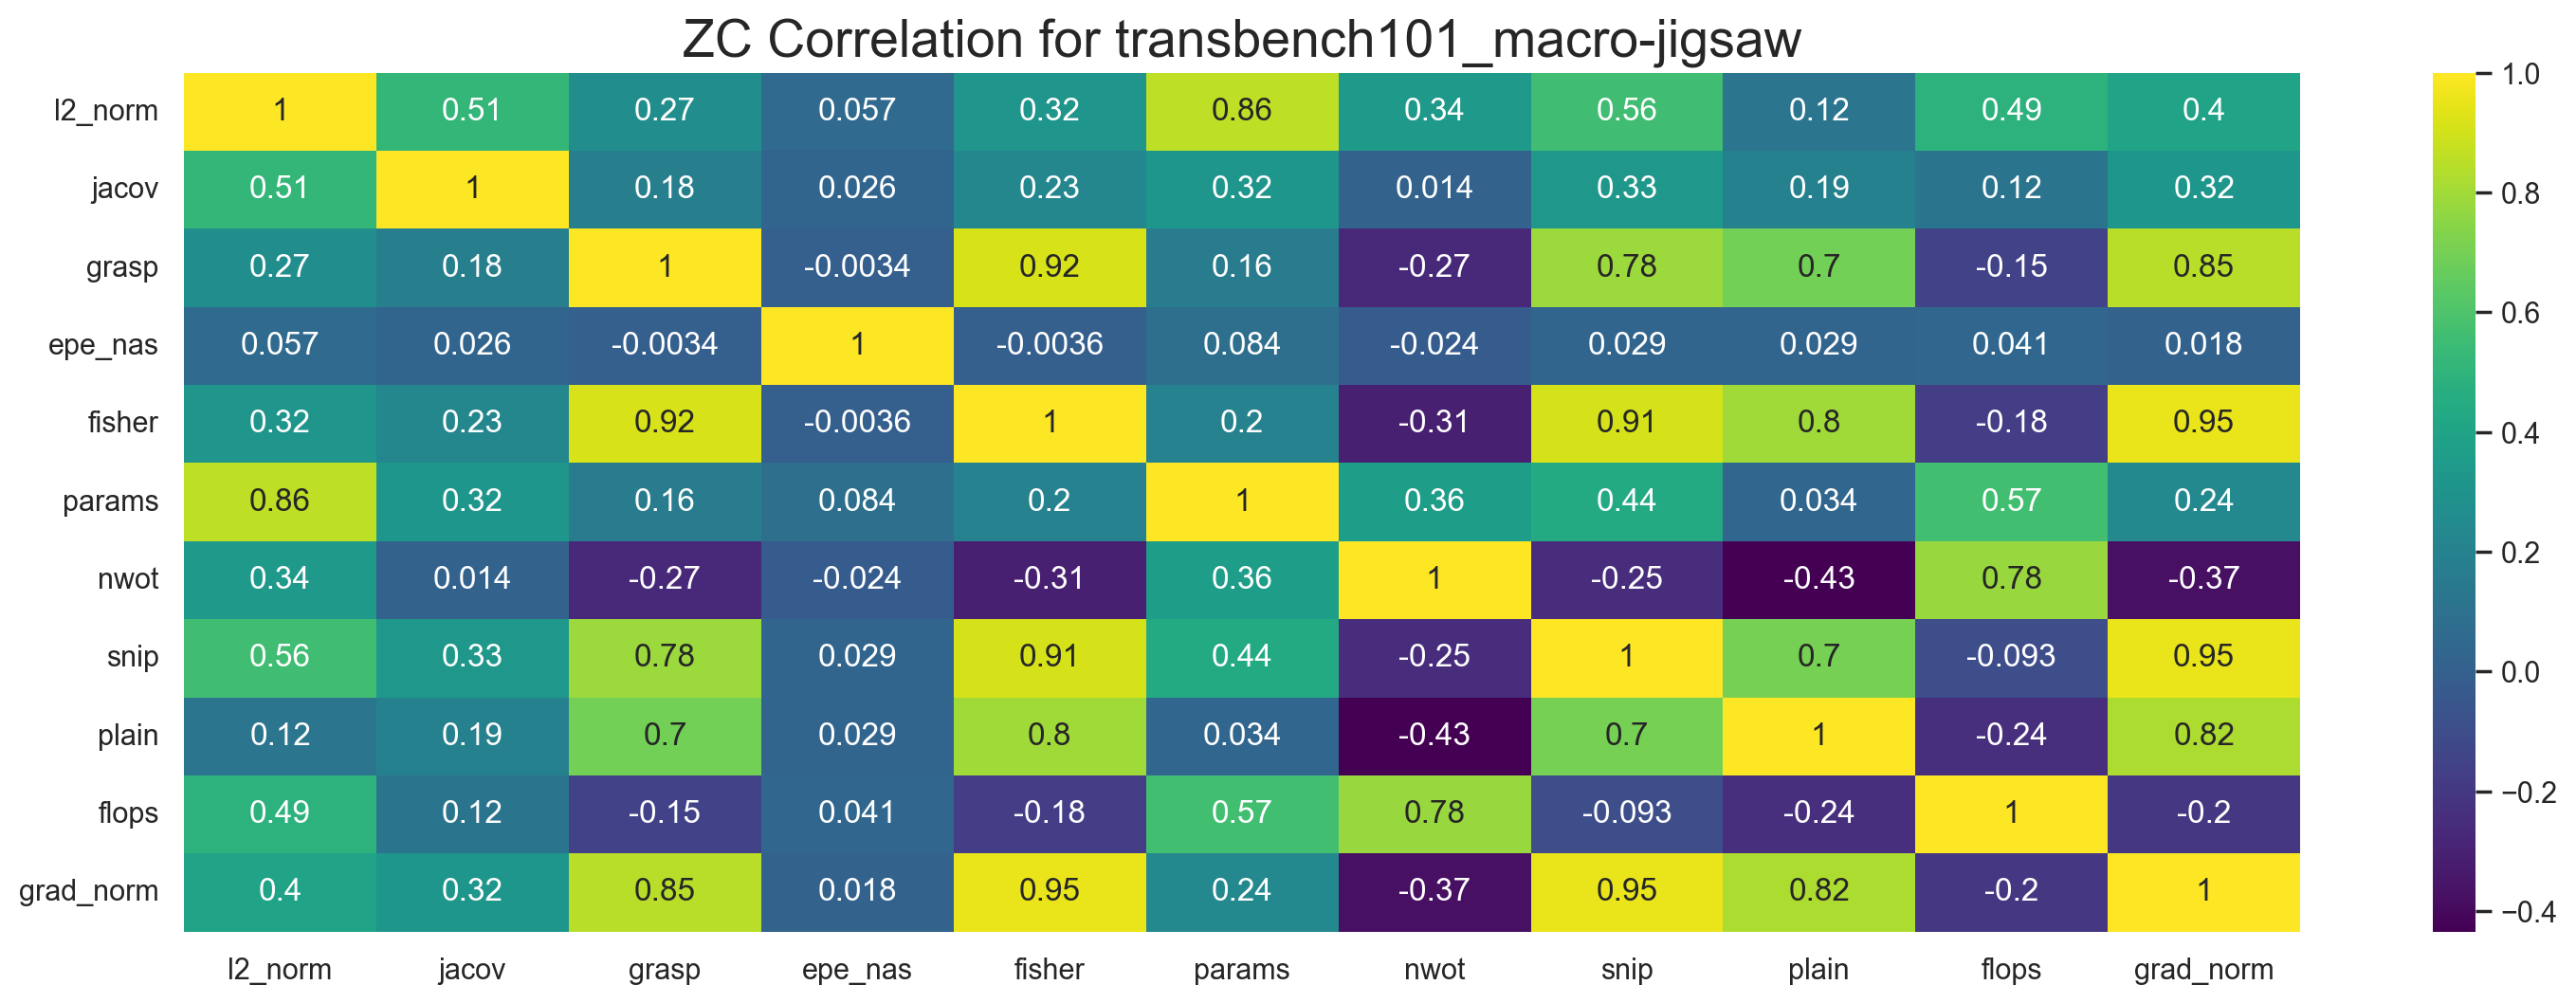

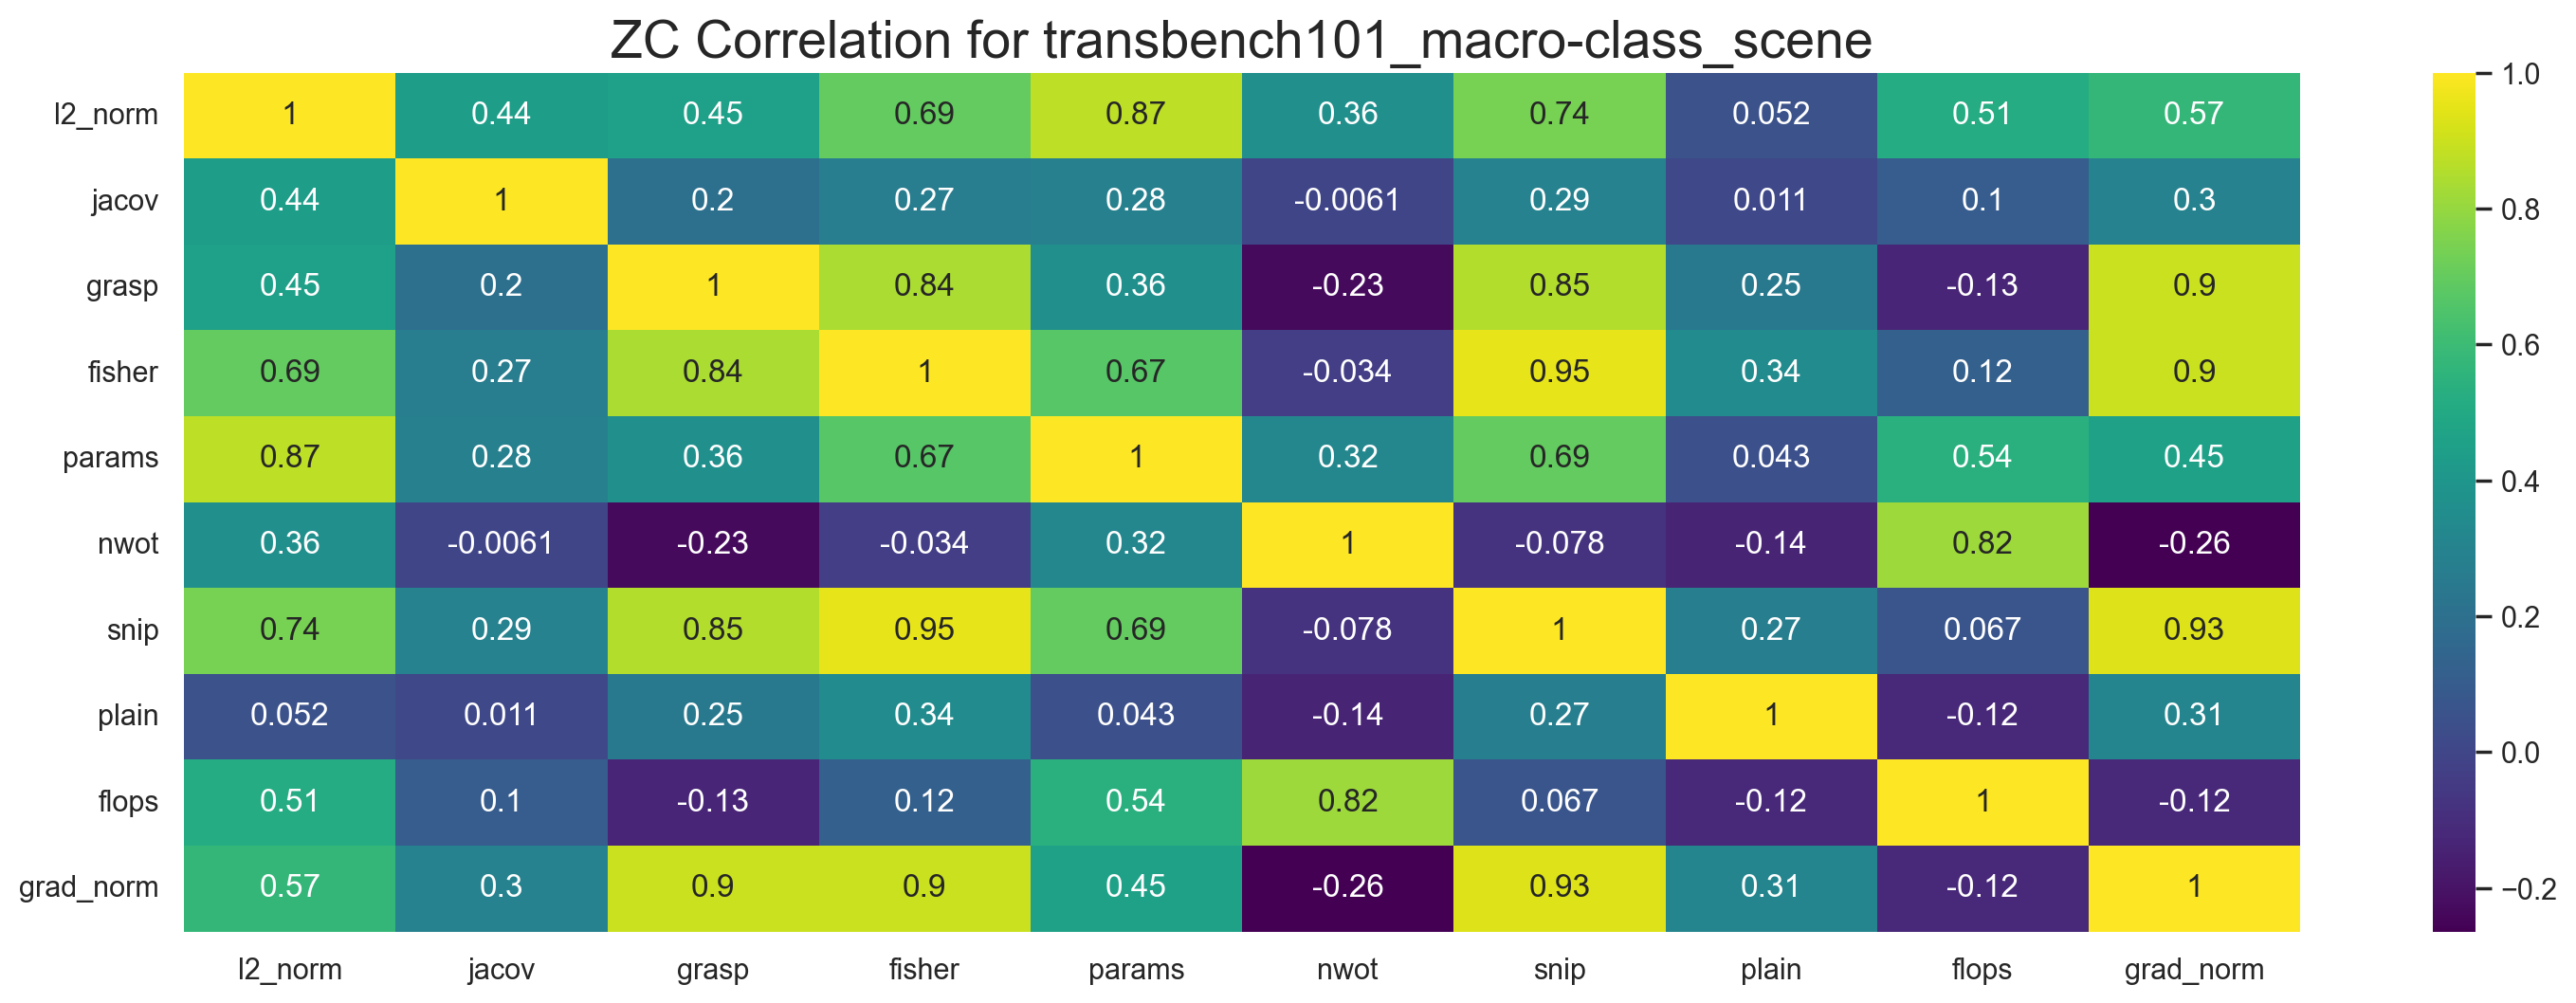

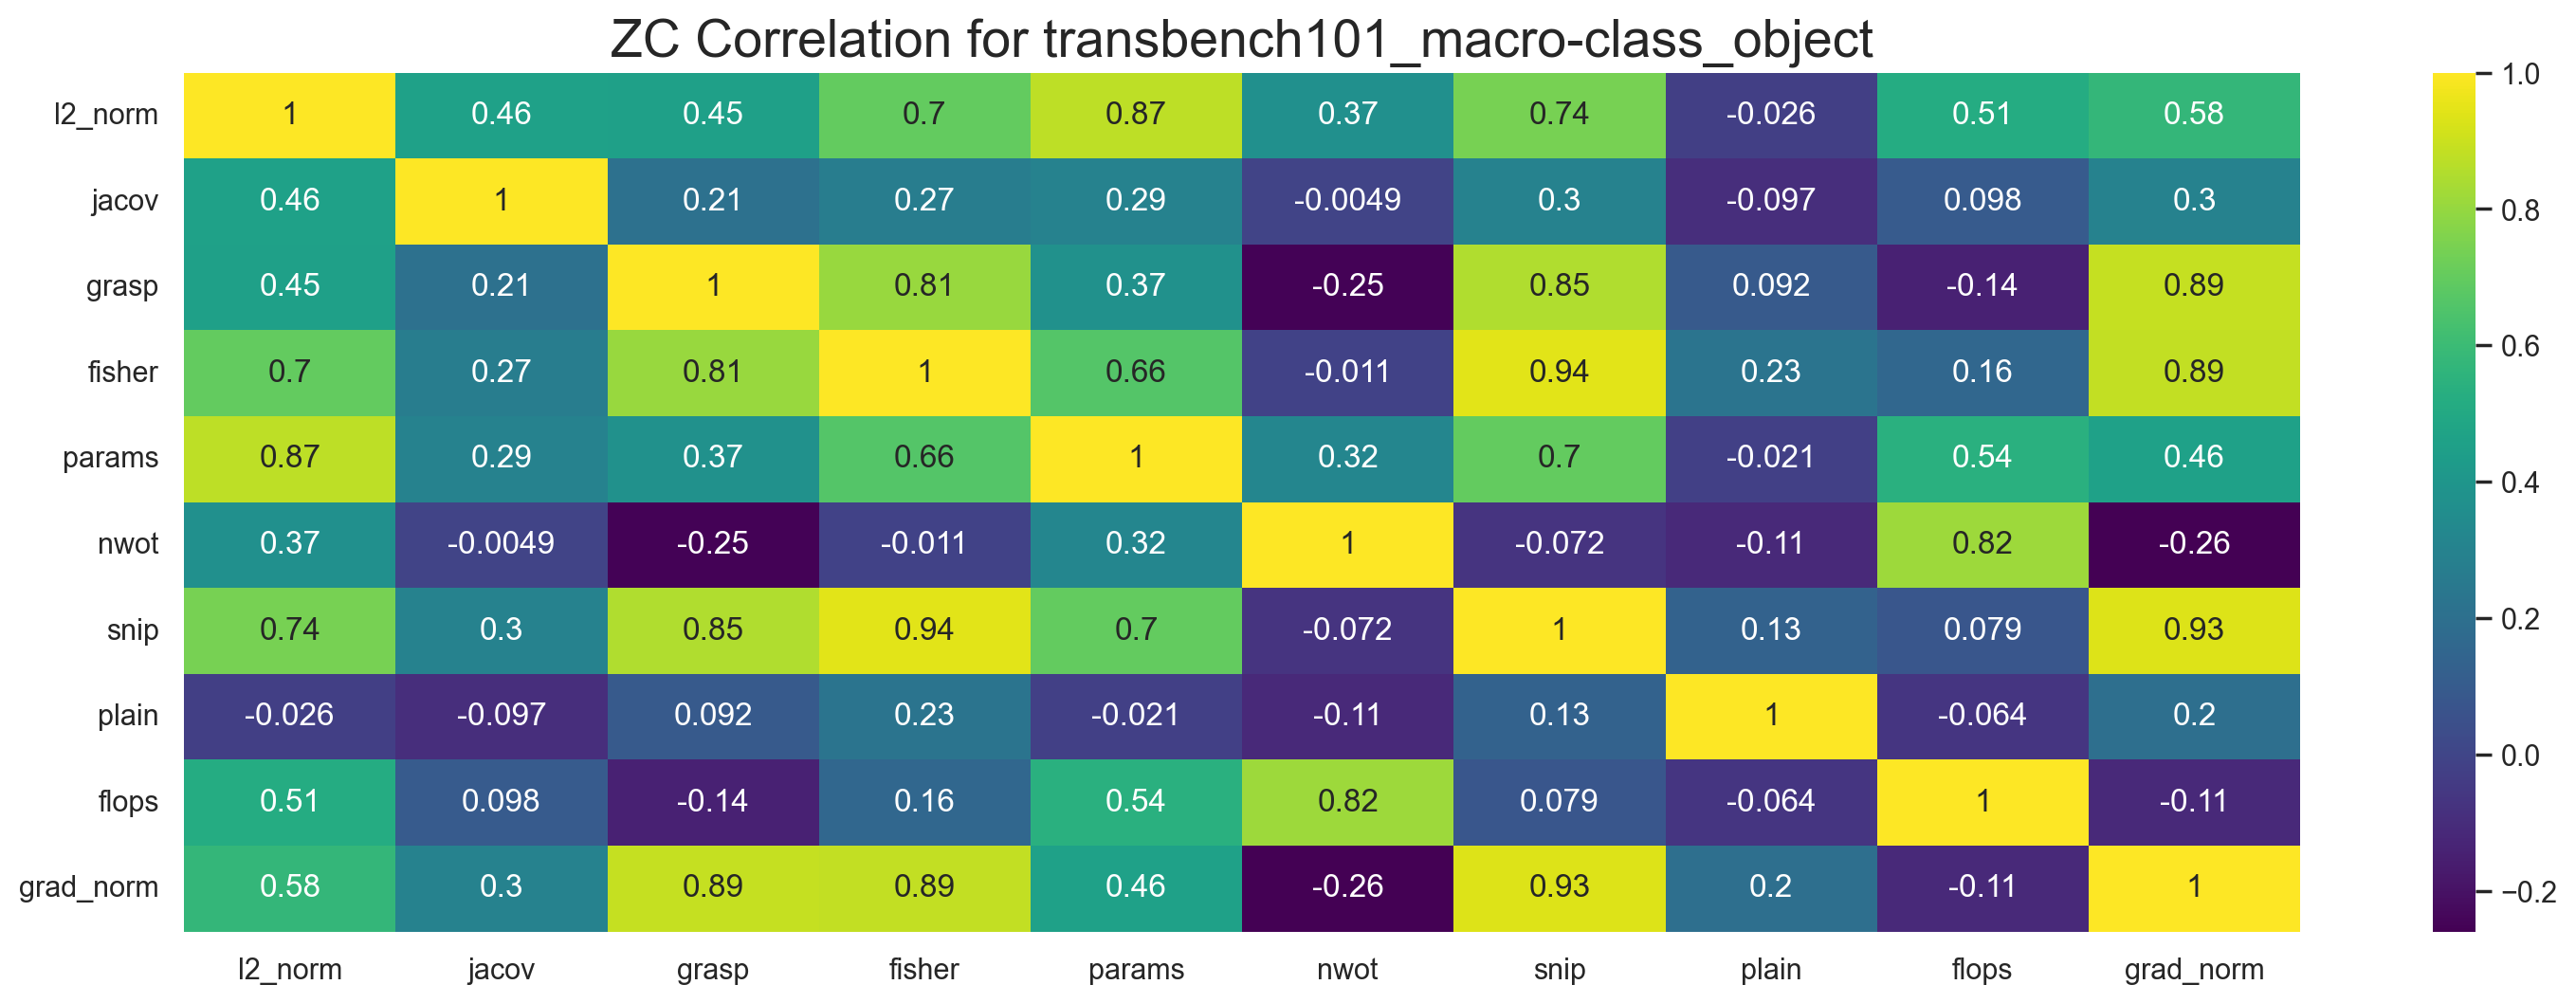

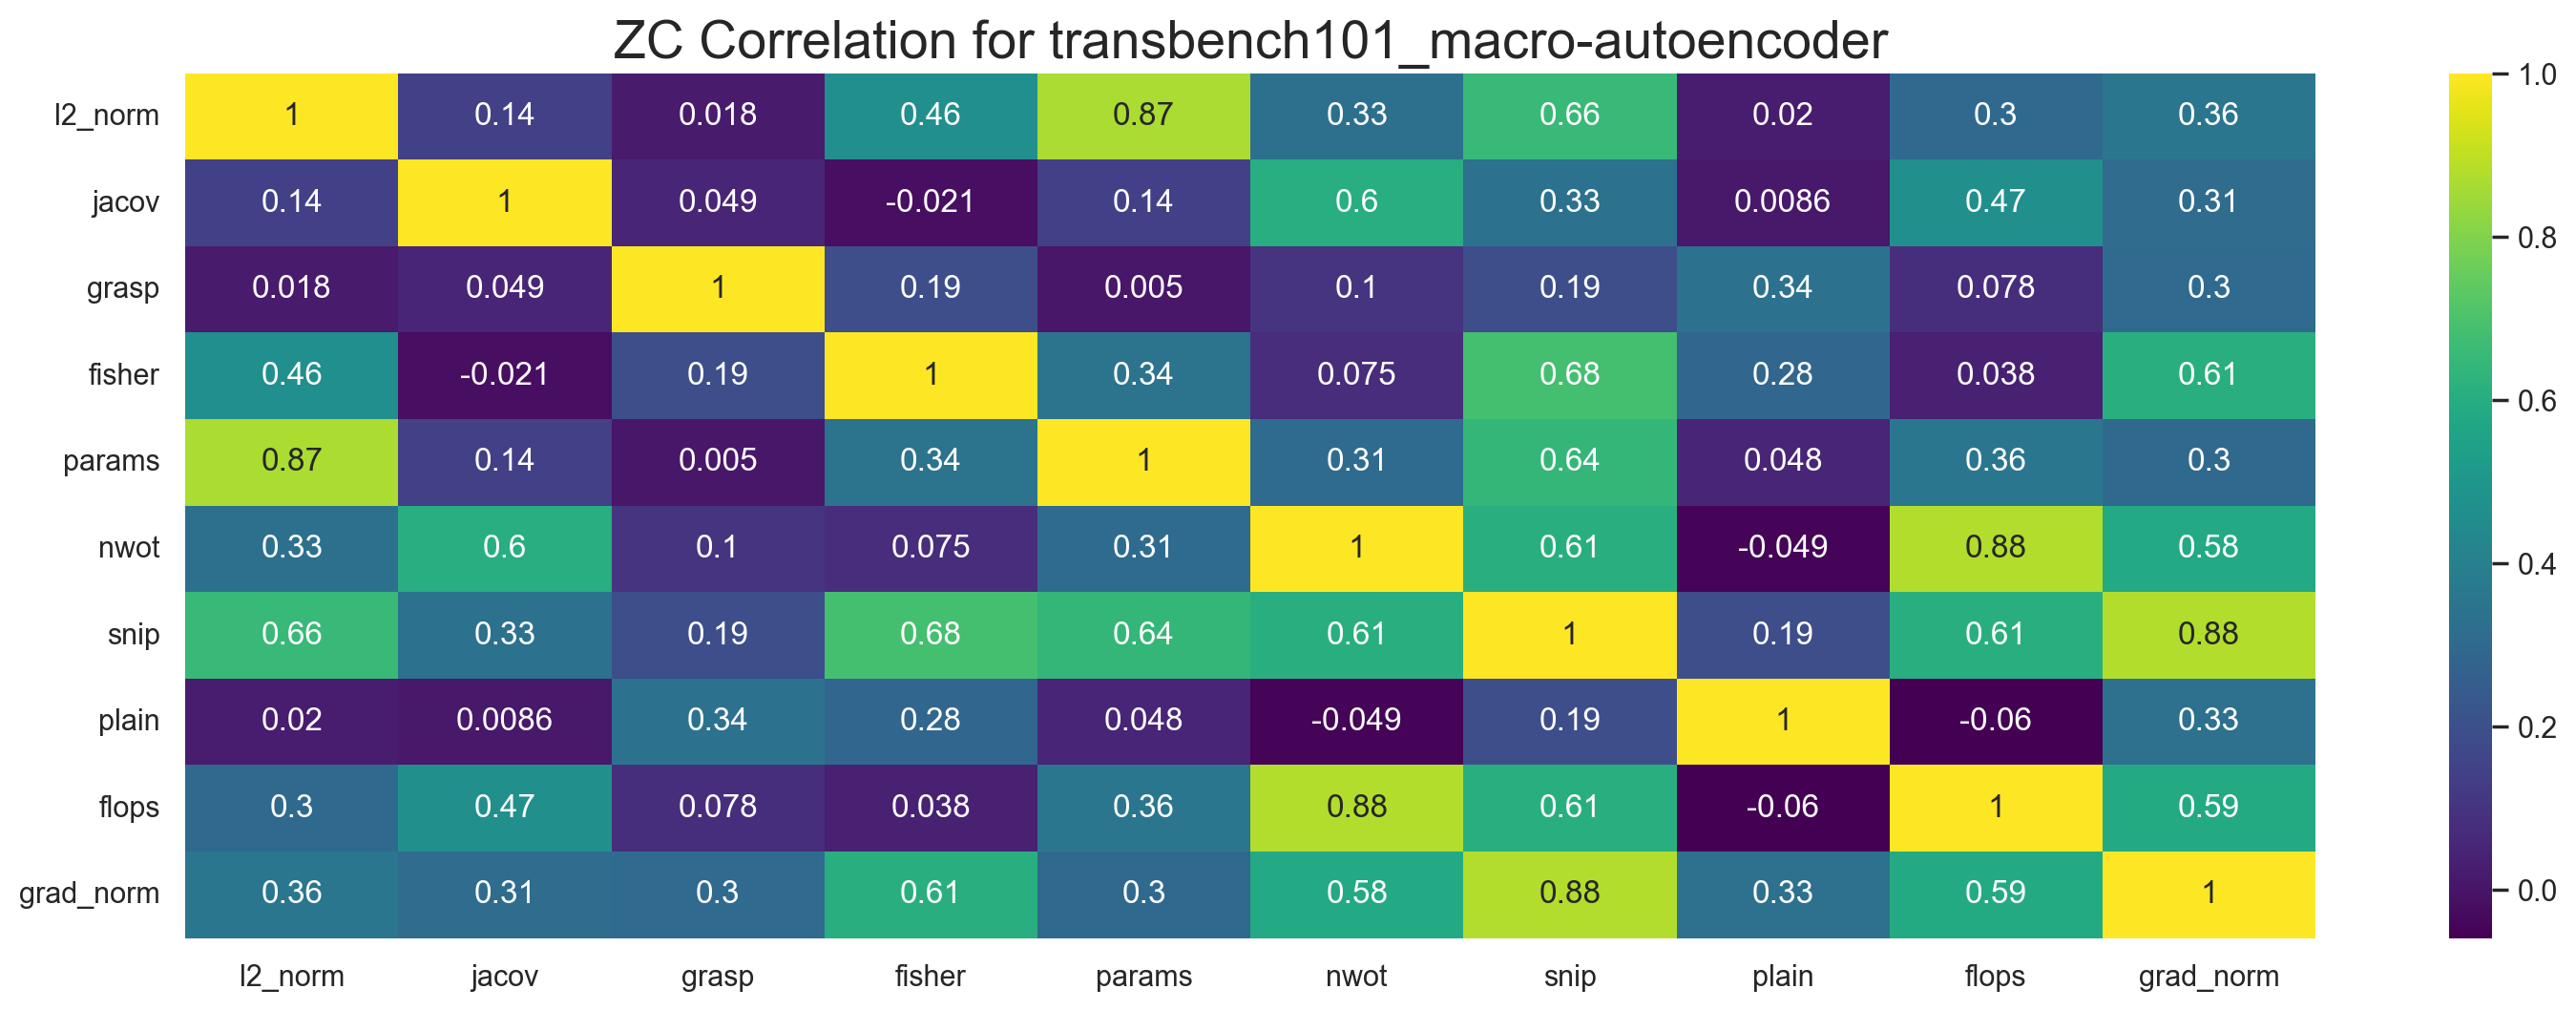

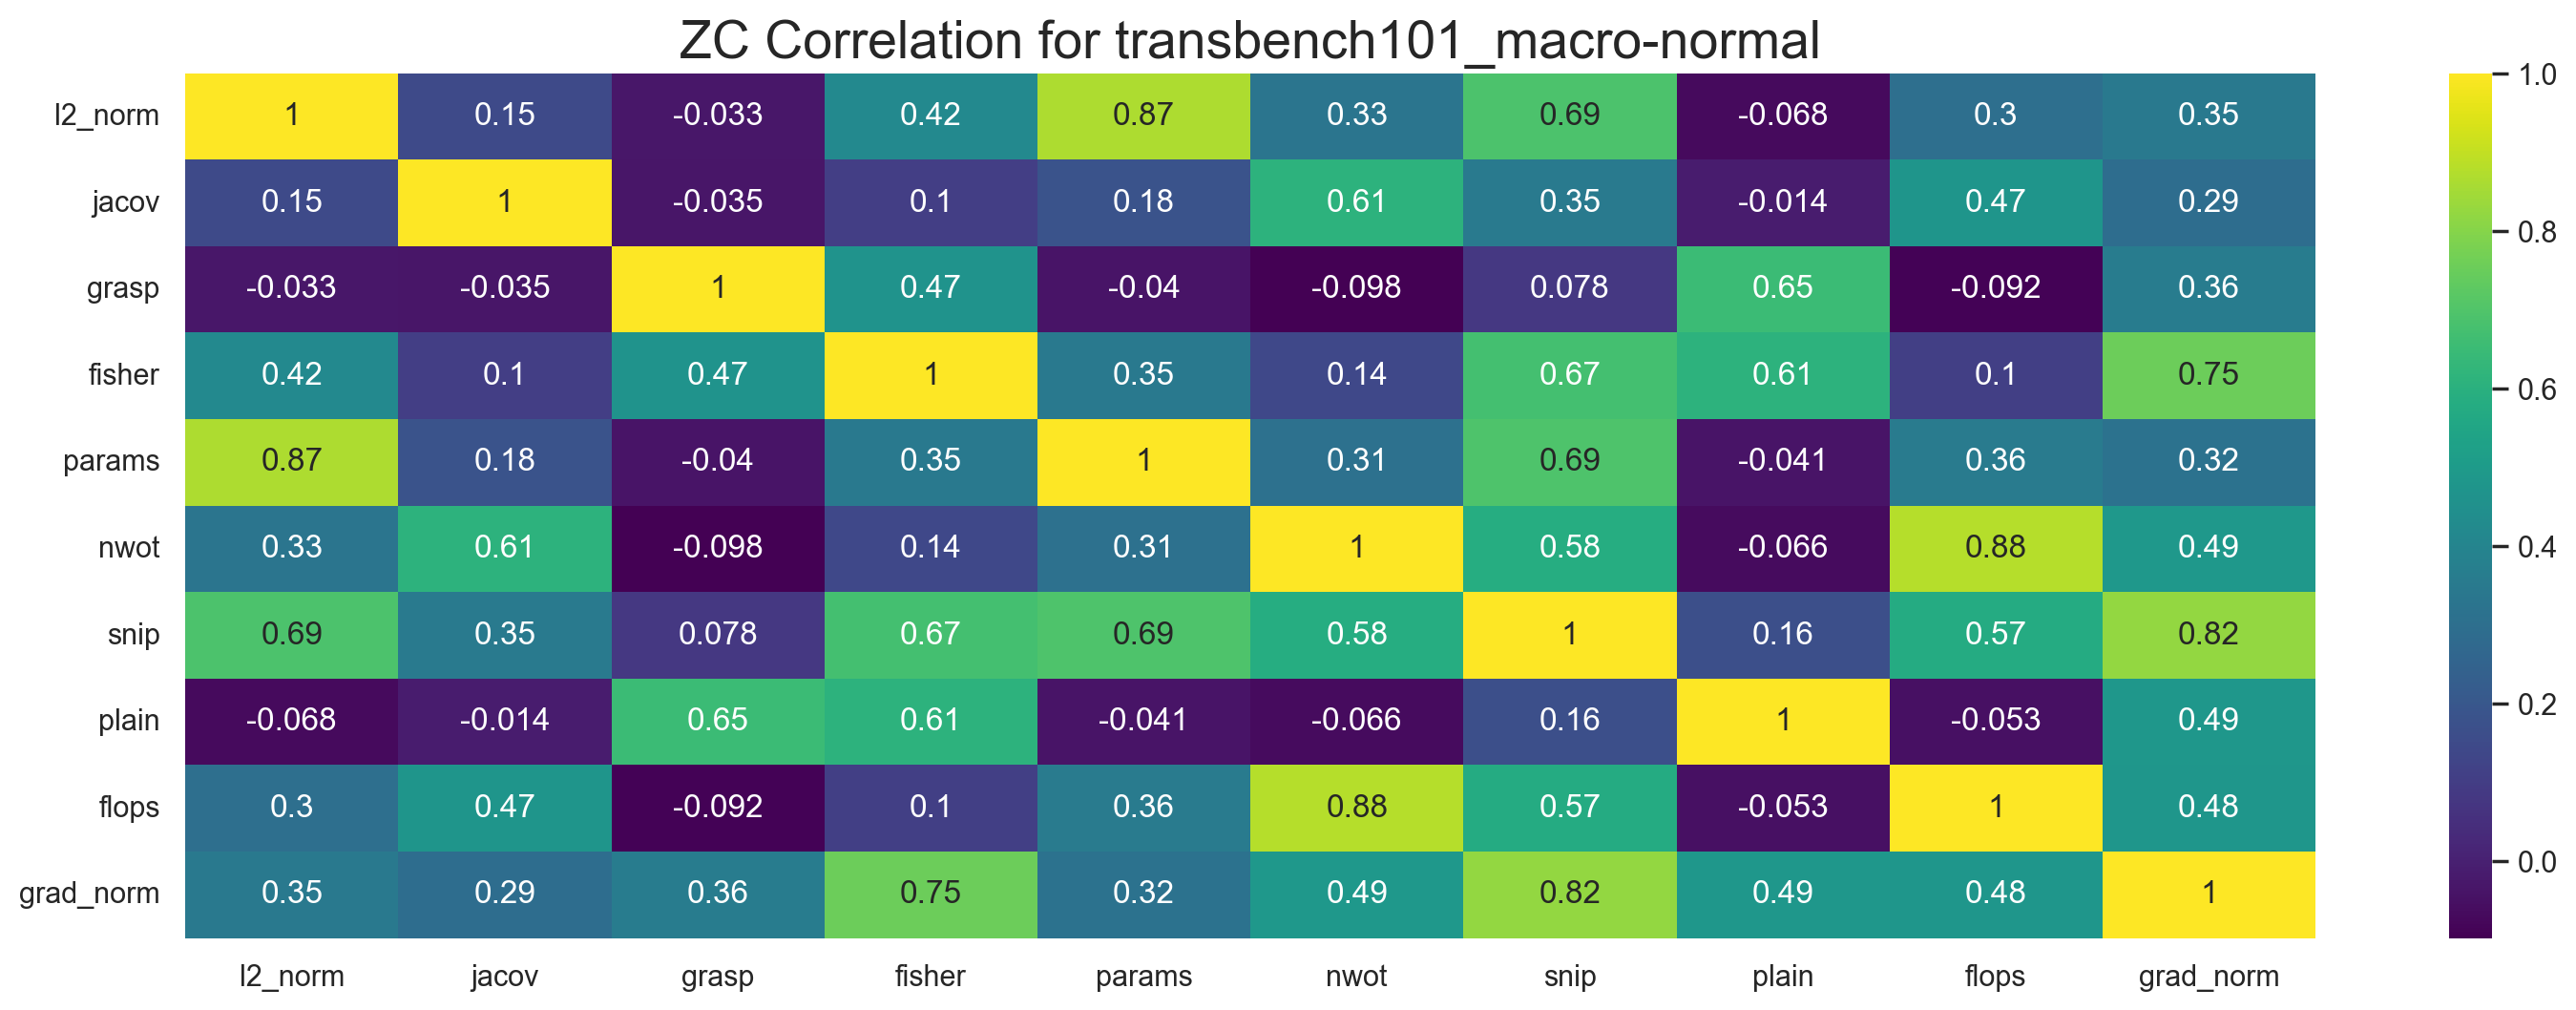

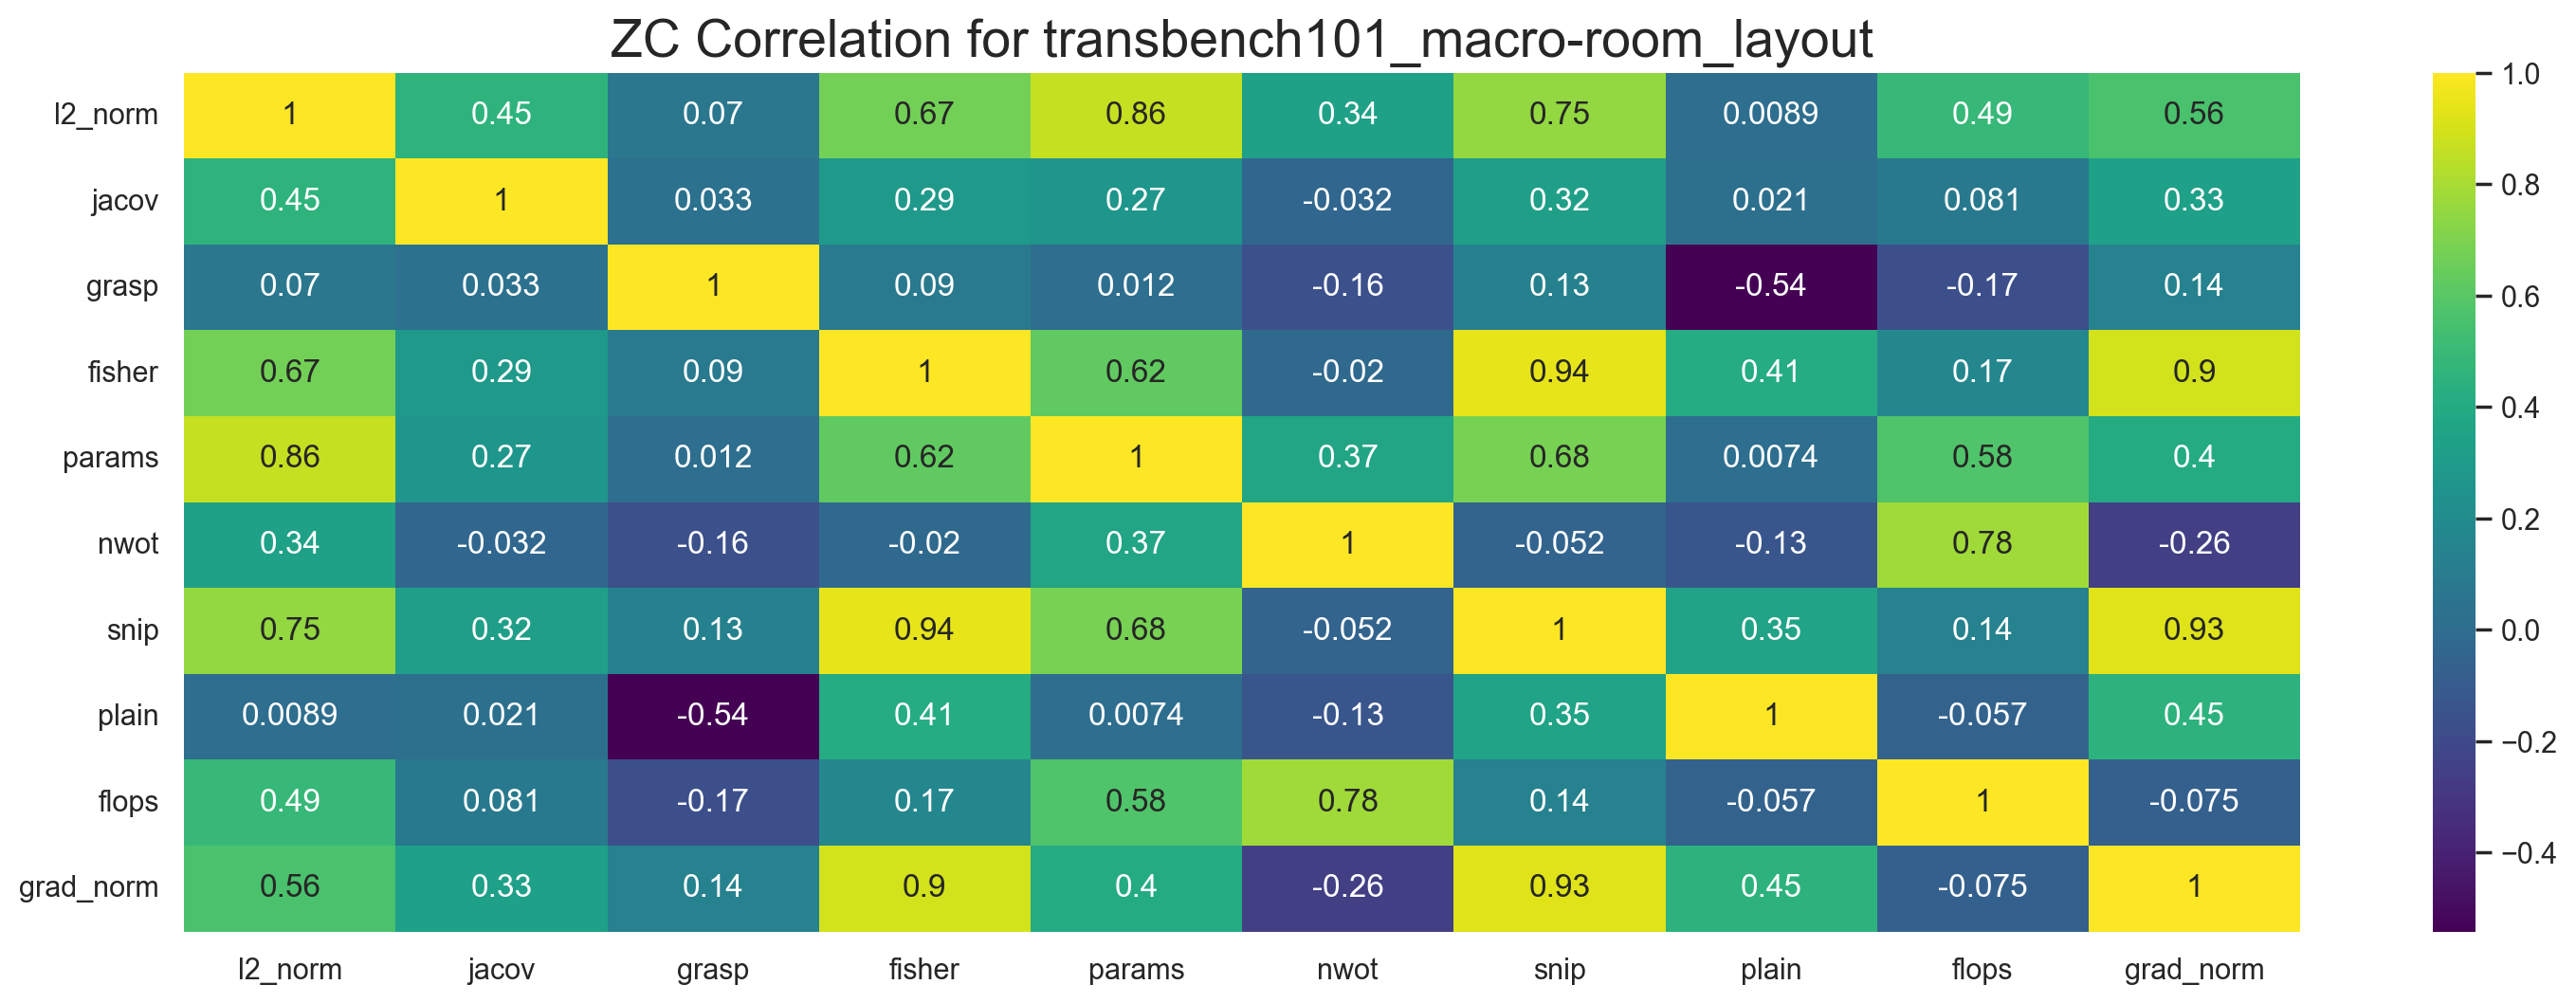

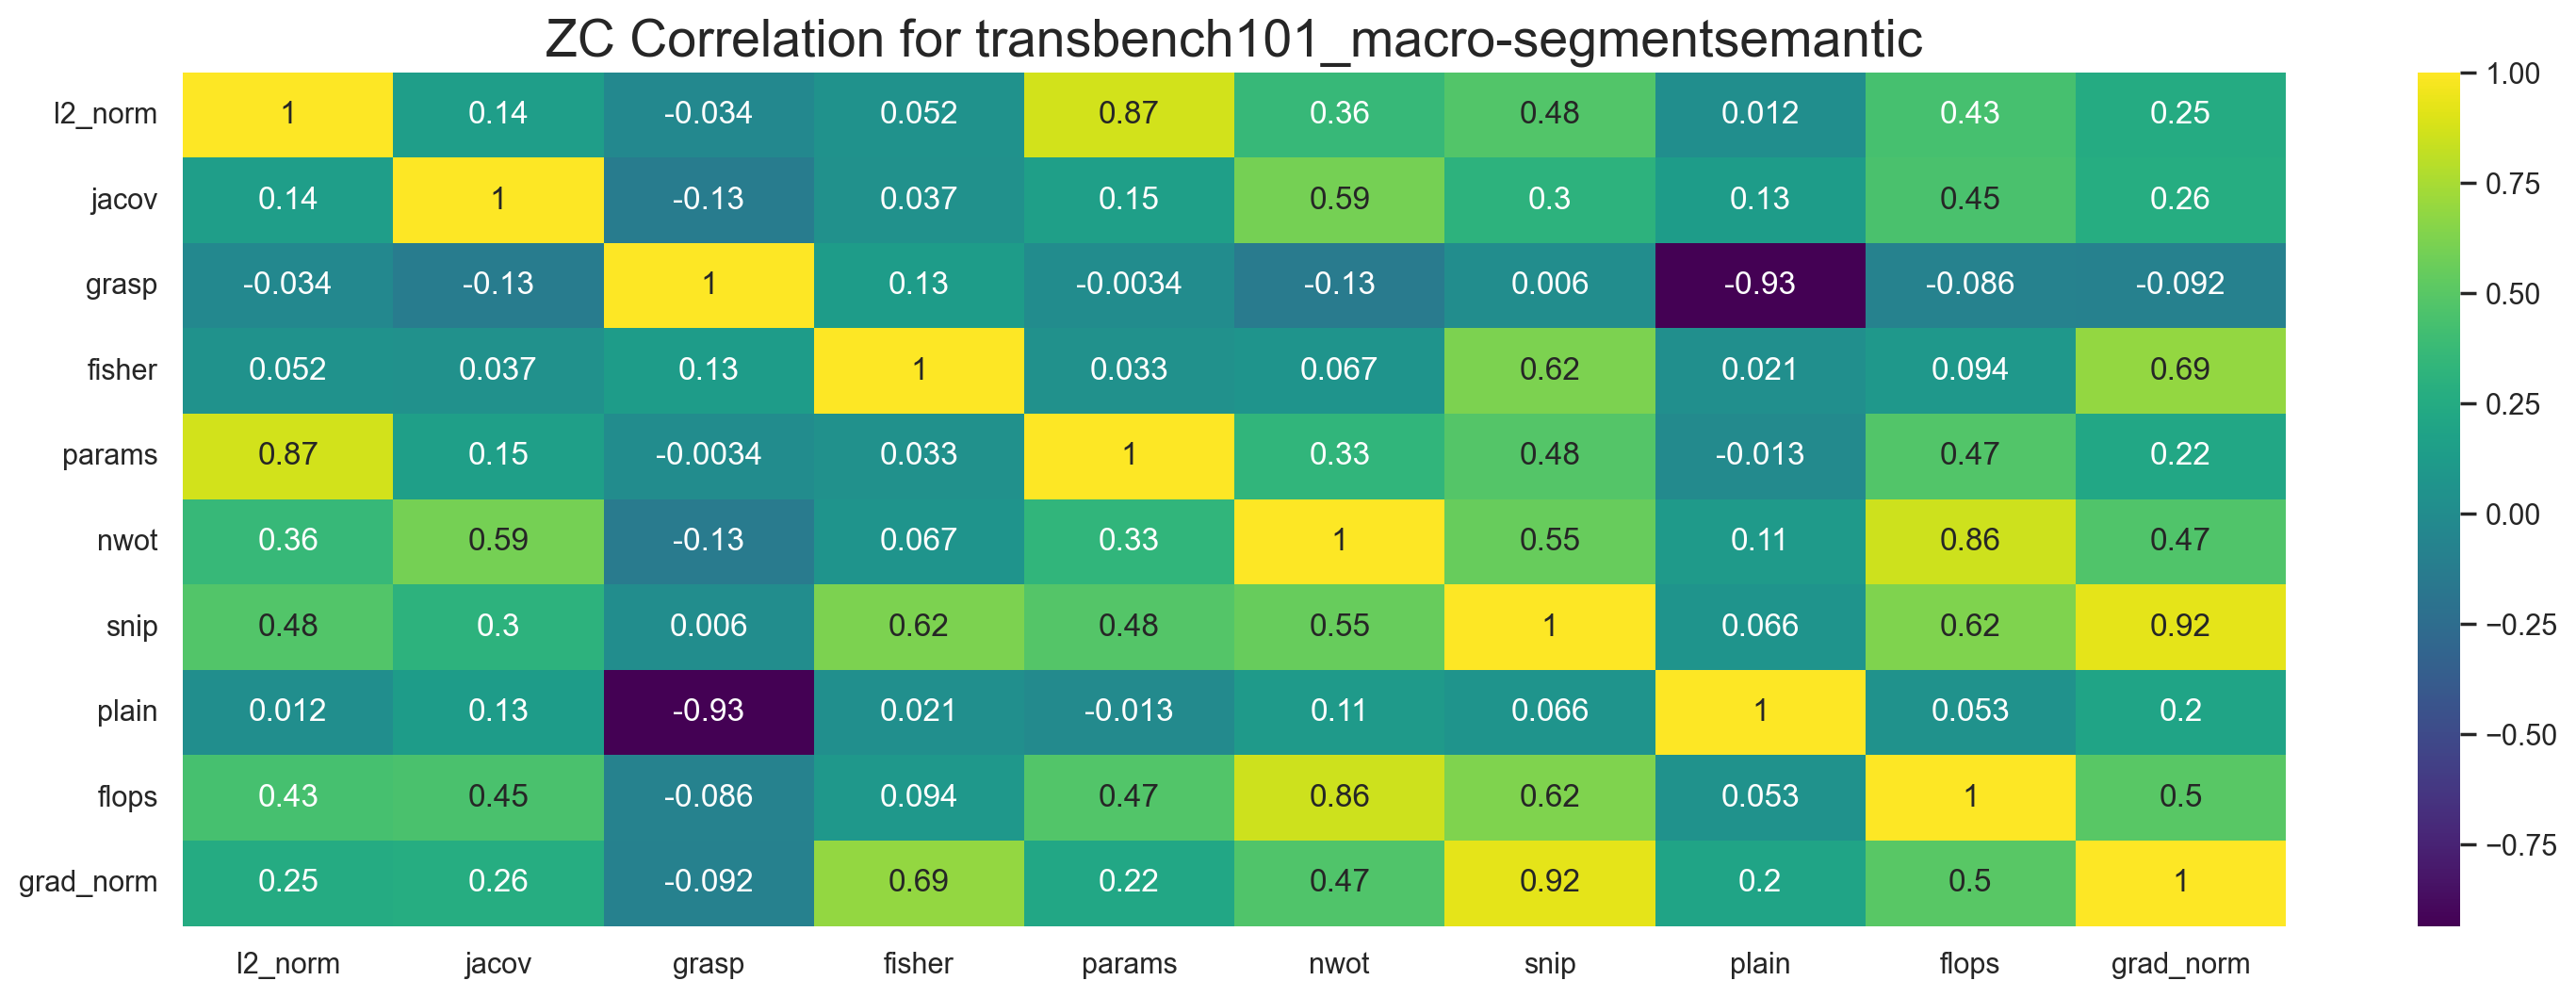

In [3]:
def make_clean_df(preds_to_drop=None):
    files = get_all_files()
    df = make_df(files)

    wrong_len_indexes = []
    wrong_type_indexes = []
    all_preds_same_indexes = []
    minus_100_indexes = []

    if preds_to_drop is not None:
        for predictor in preds_to_drop:
            df = df[df['predictor'] != predictor]
    
    for idx in df.index:
        preds = df.loc[idx]['preds']
        if not isinstance(preds, list):
            wrong_type_indexes.append(idx)
        elif len(preds) != 200:
            wrong_len_indexes.append(idx)
        elif len(set(preds)) == 1:
            all_preds_same_indexes.append(idx)
        elif -100000000.0 in preds:
            minus_100_indexes.append(idx)

    wrong_len_indexes, wrong_type_indexes, len(all_preds_same_indexes), len(minus_100_indexes)
    bad_indices = wrong_len_indexes + wrong_type_indexes + all_preds_same_indexes

    print(df.loc[wrong_type_indexes])
    df = df.drop(index=bad_indices)
    return df

df = make_clean_df()
for search_space in BENCHMARKS.keys():
    for dataset in BENCHMARKS[search_space]:
        plot_correlation_between_zcs(df, search_space, dataset)

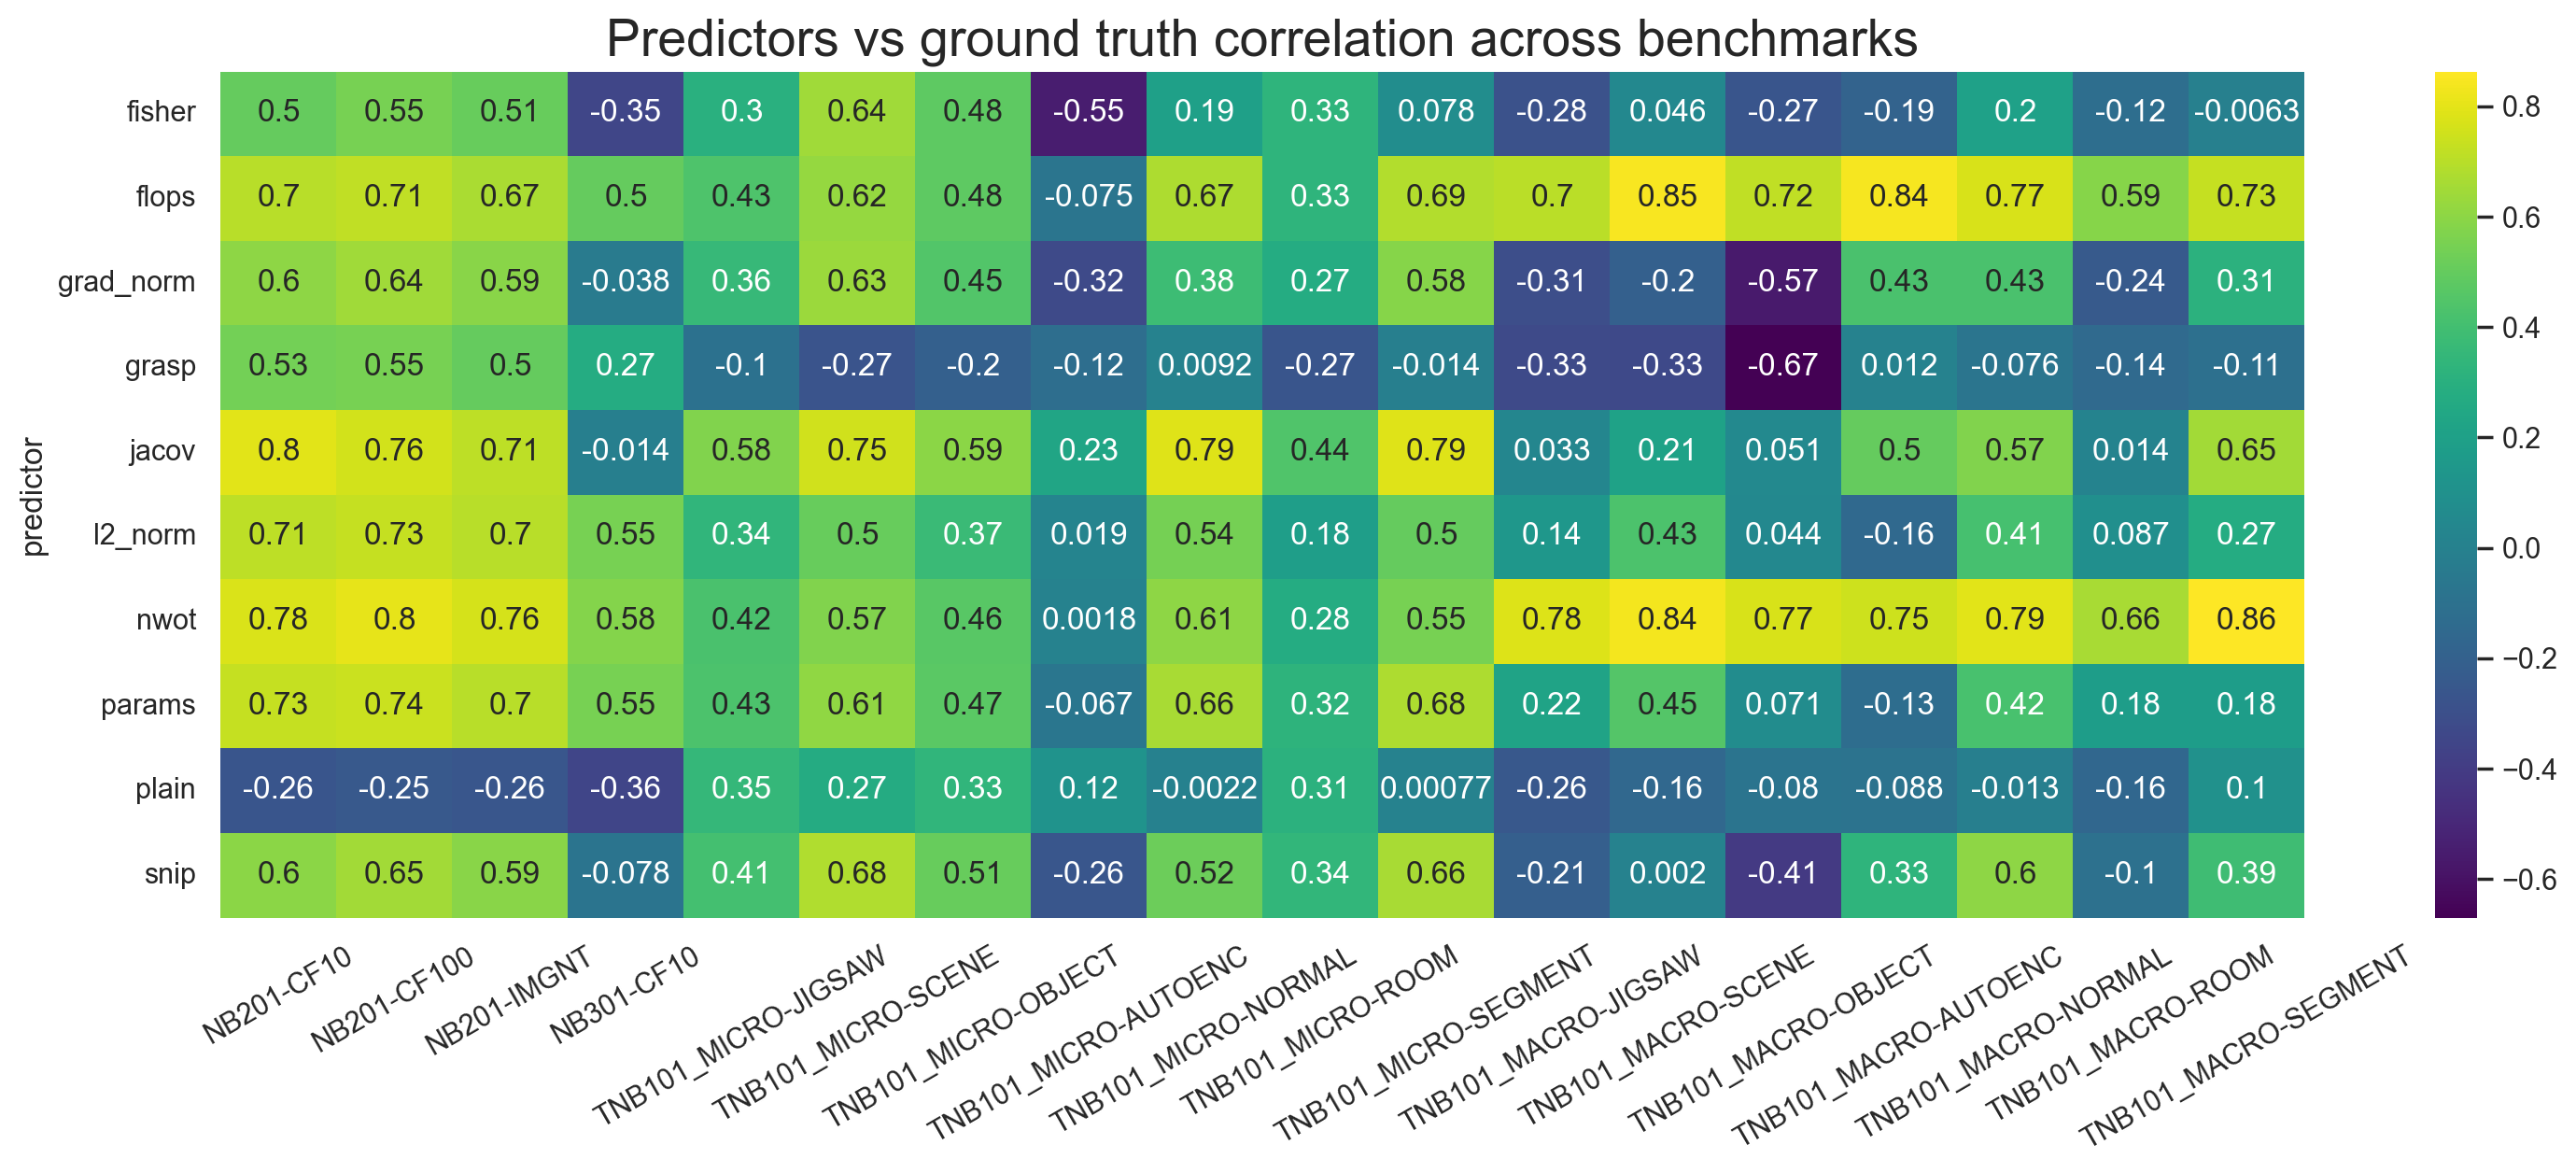

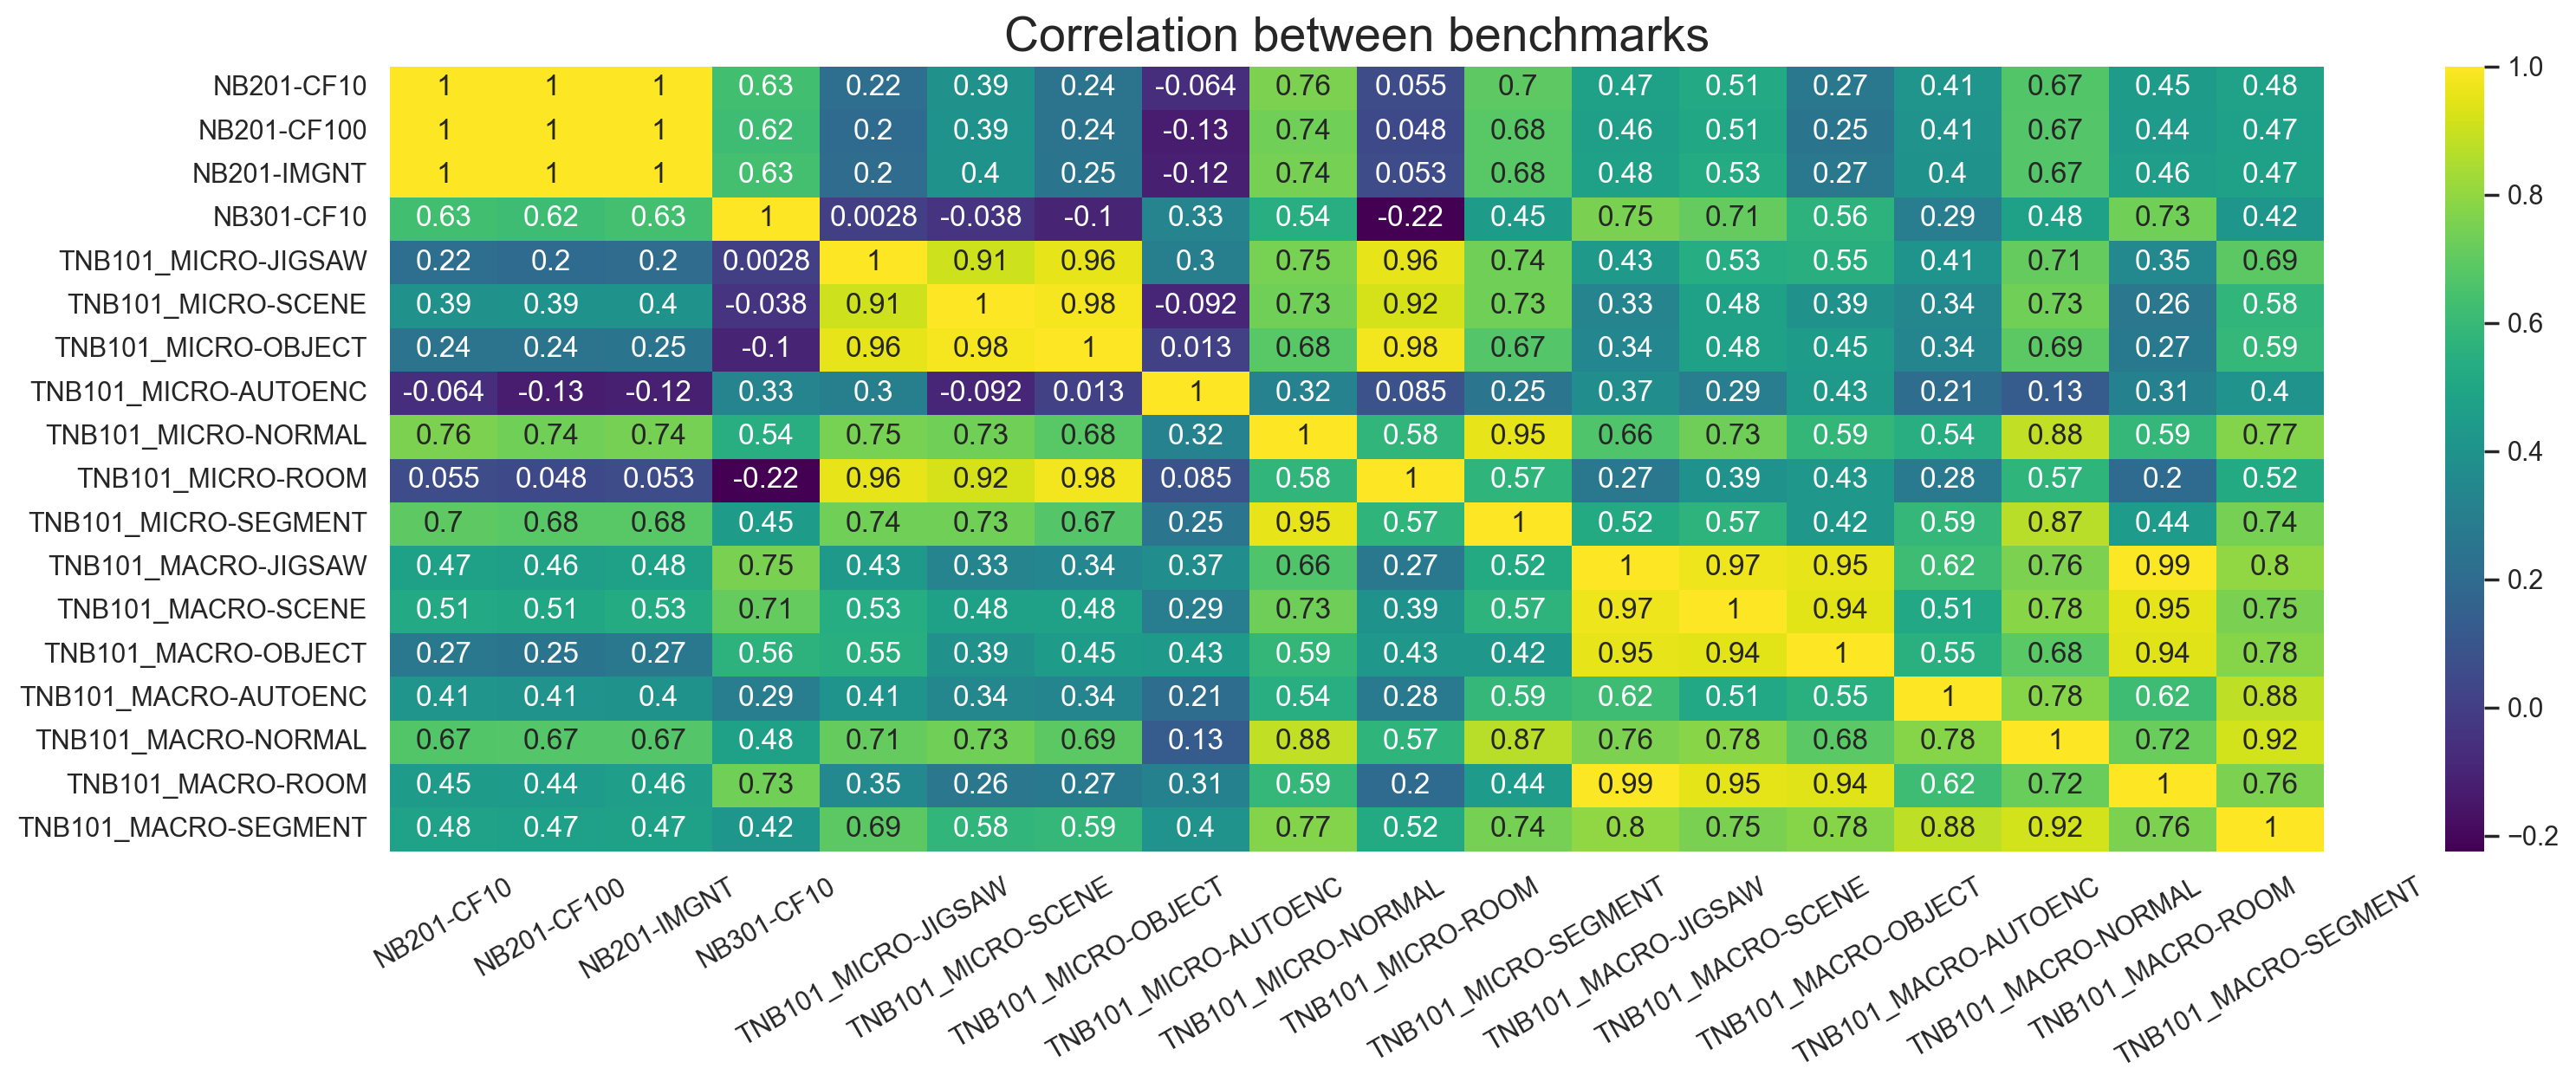

In [4]:
pred_df = make_search_space_predictors_df(df, 'spearman', BENCHMARKS)

plot_heatmap(pred_df, figsize=(18, 6), rotation=30, title='Predictors vs ground truth correlation across benchmarks')
plot_heatmap(pred_df.corr(), figsize=(18, 6), rotation=30, title='Correlation between benchmarks')

# # plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar10', 'spearman')
# # plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar100', 'spearman')
# # plot_heatmap_for_benchmark(df, 'nasbench201', 'ImageNet16-120', 'spearman')
# # plot_heatmap_for_benchmark(df, 'nasbench301', 'cifar10', 'spearman')
# # plot_heatmap_for_benchmark(df, 'nasbench101', 'cifar10', 'spearman')
# # plot_heatmap_for_benchmark(df, 'transbench101_micro', 'jigsaw', 'spearman')
# pred_df

In [9]:
show_seeds(df, 'transbench101_macro')

unique
search_space        dataset         predictor                                
transbench101_macro autoencoder     fisher     [9000, 9001, 9003, 9004, 9002]
                                    flops      [9000, 9001, 9003, 9004, 9002]
                                    grad_norm  [9000, 9001, 9003, 9004, 9002]
                                    grasp      [9000, 9001, 9003, 9004, 9002]
                                    jacov      [9000, 9001, 9003, 9004, 9002]
...                                                                       ...
                    segmentsemantic l2_norm    [9000, 9001, 9003, 9004, 9002]
                                    nwot       [9000, 9001, 9003, 9004, 9002]
                                    params     [9000, 9001, 9003, 9004, 9002]
                                    plain      [9000, 9001, 9003, 9004, 9002]
                                    snip       [9000, 9001, 9003, 9004, 9002]

[71 rows x 1 columns]